# **Intelligent Document Retrieval System**

## **Authors**
**GHIZLAN Moqim**<br>
**Thibaut JUILLARD**

## **Introduction**
This project aims to develop an advanced document retrieval system that integrates both traditional text-based search methods and graph-based approaches. The objective is to explore how incorporating document relationships within a graph structure can enhance search relevance and ranking.

We implement two versions of the search engine:
1. **Text-Based Retrieval** – A classic search engine using TF-IDF and Doc2Vec to rank documents based purely on textual similarity.
2. **Graph-Enhanced Retrieval** – A more advanced approach where documents are modeled as nodes in a graph, and relationships between them (e.g., shared authors, citations, or thematic similarities) are leveraged to improve search results.

By comparing these two methodologies, we assess the impact of network structures on information retrieval, evaluating their performance in terms of accuracy and relevance. The project combines Natural Language Processing (NLP), machine learning, and network science to provide deeper insights into the potential of graph-based search systems.

## **Structure of the Project**  

This project contains the following files:  

- `./main.ipynb`: The main file containing the implementation of the project.  
- `./utility.py`: A utility file containing the functions used in the main file.  
- `./models.py`: A file containing the functions used to apply different machine learning models.  
- `./graphic.py`: A file containing functions for graph visualization and network analysis.  
- `./src/data/data_project.csv`: The dataset used in the project.  
- `./src/files/<file_name>.pdf`: Documents provided by J.V. detailing the project requirements and final results expected.
- `./src/tds/<file_name>.py`: Files previded by J.V. for the project.
- `./rapport.pdf`: A report detailing the methodology, results, and conclusions of the project.
- `./sigma_graph.html`: A visualization of the graph constructed in section 5.2 AKA graph construction and analysis.
- `./graph_visualization.svg`: A visualization of the graph constructed in section 5.2 AKA graph construction and analysis.

## **This main file is structured as follows:**  

### **1. Installation & Implementation**  
Setting up the required dependencies and environment to execute the project.  

### **2. Data Preprocessing**  
Preparing and cleaning the dataset, including text processing and feature extraction.  

### **3. First Search Engine**  
Implementation of a traditional text-based search engine using TF-IDF and Doc2Vec.  

### **4. Graph Construction**  
- **Graph Preparation:** Transforming the dataset into a network representation.  
- **Graph Properties and Analysis:** Studying key metrics such as centrality, connectivity, and clustering.  

### **5. Supervised Classification**  
- **Baseline: TF-IDF Classification:** Applying machine learning models on textual features.  
- **Improvement with Node2Vec:** Integrating graph-based embeddings to improve classification.  
- **GridSearchCV & Hyperparameter Tuning:** Optimizing model performance.  
- **Comparison of the Improved Models:** Evaluating the effect of combining graph and text representations.  

### **6. Representation of Articles & Authors**  
- **Data Preprocessing for Author Representation:** Extracting author-related features.  
- **Barycenter Calculation:** Computing the central representation of an author's contributions.  
- **Author Search:** Implementing a system to retrieve documents based on author similarities.  

This structure ensures a comprehensive analysis of document retrieval using both text-based and graph-based methodologies, demonstrating their respective advantages and limitations.  



# Installation & implementation

### Installing all required libraries at once

In [1]:
!pip install numpy pandas matplotlib seaborn scipy scikit-learn statsmodels gensim nltk spacy openpyxl xlrd plotly umap-learn pyLDAvis wordcloud networkx tqdm  pyvis python-louvain ipysigma scikit-network node2vec xgboost lightgbm

### Importing all required libraries at once

In [2]:
import re
import gc
import random
import string
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.sparse import csr_matrix, hstack
import scipy.sparse.linalg as spla

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.collocations import (
    BigramAssocMeasures,
    TrigramAssocMeasures,
    BigramCollocationFinder,
    TrigramCollocationFinder
)

from collections import Counter, defaultdict
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import networkx as nx
import community as community_louvain
from sknetwork.visualization import svg_graph
from IPython.core.display import display, SVG
from node2vec import Node2Vec

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    silhouette_score,
    adjusted_rand_score,
    pairwise_distances
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.metrics.pairwise import cosine_similarity

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

from ipysigma import Sigma
import networkx as nx
import random
import warnings

C:\Users\moqimq\AppData\Local\Temp\ipykernel_9392\3432135698.py:32: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, SVG


### Ignoring warnings

In [3]:
warnings.filterwarnings("ignore")

### Importing all custom functions

In [4]:
# Loading functions from ./utility.py
from utility import *

In [5]:
# Loading functions from ./models.py
from models import *

In [6]:
# Loading functions from ./graphic.py
from graphic import *

# Data preprocessing

### Loading the data from local files

In [7]:
# Load the dataset from the specified CSV file using the fetch_data function from utility.py
data = fetch_data('./src/data/data_project.csv')

### Analysis of the data

In [8]:
# Perform exploratory data analysis (EDA) on the dataset using the data_analyse function from utility.py
data_analyse(data)

Preview of the first few rows:
                                               venue  \
0  international conference on human-computer int...   
1            visual analytics science and technology   
2       pattern recognition and machine intelligence   
3  international conference on computer graphics ...   
4  international symposium on computer and inform...   

                                            abstract  \
0  The purpose of this study is to develop a lear...   
1  This paper describes the design and implementa...   
2  This article applied GARCH model instead AR or...   
3                                                NaN   
4                                                NaN   

                                             authors  n_citation  \
0  ['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...           0   
1                    ['Gareth Beale', 'Graeme Earl']          50   
2  ['Altaf Hossain', 'Faisal Zaman', 'Mohammed Na...          50   
3  ['Rafael Álvarez', '

Results's Interpretation:

The dataset comprises 40,596 academic articles spanning multiple decades, with a notable concentration from 2000 to 2014. The number of citations varies widely, with most articles having zero citations, but some reaching up to 2,531. Abstracts are missing in more than half of the entries, potentially affecting text-based analyses. The data includes 38,990 unique authors, suggesting a highly diverse authorship network. The venue names, abstract lengths, and title lengths exhibit significant variation, reflecting differences in publication norms. The data structure, combining textual, numerical, and networked citation relationships, offers rich opportunities for text mining, author influence analysis, and citation network studies.


# First search engine

#### Data Preprocessing

In [9]:
# Initialize the English stemmer from NLTK's SnowballStemmer
stemmer = SnowballStemmer("english")

# Replace missing values in the dataset with empty strings to avoid processing errors
data = data.fillna('')

# Create a new 'text' column by concatenating 'venue', 'title', and 'abstract'
data['text'] = data['venue'] + ' ' + data['title'] + ' ' + data['abstract']

# Apply text preprocessing (tokenization, stopword removal, stemming) using preprocess_text from utility.py
data['processed_text'] = data['text'].apply(lambda x: preprocess_text(x, stemmer))

# Initialize a TF-IDF Vectorizer with specified frequency thresholds
# - Ignore words that appear in more than 85% of documents (max_df)
# - Ignore words that appear in fewer than 2 documents (min_df)
vectorizer = TfidfVectorizer(max_df=0.85, min_df=2)

# Fit the vectorizer and transform the preprocessed text into a TF-IDF representation
X = vectorizer.fit_transform(data['processed_text'])

# Retrieve TF-IDF scores for each word in the vocabulary
word_scores = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

# Sort words by their TF-IDF scores in descending order
sorted_word_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame containing the top 30 words based on their TF-IDF scores
top_words = pd.DataFrame(sorted_word_scores[:30], columns=['Word', 'Score'])

# Compute raw word frequencies using word_frequencies from utility.py
res_freq = word_frequencies(data, 'processed_text')

# Define sets of punctuation characters and English stopwords for filtering
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

# Remove punctuation and stopwords from the top TF-IDF words and raw frequency lists
top_words = top_words[~top_words['Word'].isin(punctuation)]
top_words = top_words[~top_words['Word'].isin(stop_words)]
res_freq = res_freq[~res_freq['Word'].isin(punctuation)]
res_freq = res_freq[~res_freq['Word'].isin(stop_words)]

#### Display TF-IDF scores in the console

In [10]:
# Print the top 30 most frequent words along with their TF-IDF scores
print("\nTop 30 most frequent words with their TF-IDF scores:")
print(top_words.to_string(index=False))  # Display the DataFrame without row indices for better readability



Top 30 most frequent words with their TF-IDF scores:
     Word       Score
   confer 1325.895263
   system 1264.369550
   intern 1222.012340
   comput 1070.107493
   inform  922.519269
    model  883.586908
      use  823.713440
     data  764.838091
   speech  714.326320
   applic  680.824712
  network  660.273178
  process  656.305800
 intellig  632.009139
 communic  628.171826
algorithm  603.122083
     base  598.229017
    engin  548.704026
   associ  523.995237
 parallel  522.208527
distribut  516.506138
   method  511.789587
 approach  499.525013
 artifici  478.611391
      bas  467.360495
  softwar  464.146185
    learn  463.315562
  problem  445.222101
      web  444.631400
   design  436.139568
  languag  422.154165


Results's Interpretation:

The most frequent words identified by the TF-IDF analysis reflect key themes in the dataset, emphasizing technical and academic domains. Words such as "conference," "system," "computer," and "information" suggest a strong focus on computing and information sciences. The presence of terms like "speech," "network," "algorithm," and "artificial" highlights discussions around artificial intelligence, data processing, and distributed computing. Additionally, "method," "approach," and "learning" indicate a methodological emphasis, reinforcing the dataset’s focus on research-driven advancements in technology and computational sciences.

#### Display raw word frequencies in the console


In [11]:
# Print the top 30 most frequent words based on raw frequency counts
print("\nTop 30 most frequent words (raw frequency):")
print(res_freq.head(30).to_string(index=False))  # Display the DataFrame without row indices for better readability



Top 30 most frequent words (raw frequency):
     Word  Frequency
      use      20936
   system      18791
   confer      17519
   comput      14938
   intern      14477
    model      13931
   inform      11917
     data      10672
     base      10563
algorithm       9430
   propos       9028
   method       8864
  network       8118
   applic       8037
 approach       8023
   result       7734
  process       7716
    paper       7686
  problem       6950
 intellig       6844
  present       6762
     show       6177
    learn       6072
  perform       6014
      new       5702
  develop       5446
   design       5420
 communic       5054
     imag       4967
   differ       4956


Results's Interpretation:


The raw frequency analysis highlights the dominant terms in the dataset, revealing a strong emphasis on computing, systems, and information science. High-frequency words such as "use," "system," "conference," and "computer" indicate a focus on practical applications and technological discussions. Terms like "algorithm," "model," "data," and "network" reflect an interest in machine learning, artificial intelligence, and computational methods. Additionally, "method," "approach," and "process" reinforce the research-driven nature of the dataset, while "result," "paper," and "present" suggest an emphasis on academic reporting and knowledge dissemination.

#### Compute accuracy with TF-IDF

In [12]:
# Compute the classification accuracy using TF-IDF vectorization and a Naïve Bayes model
# The function compute_accuracy comes from utility.py
accuracy_tfidf = compute_accuracy(data, 'processed_text', 'class', vectorizer_type='tfidf')

# Print the accuracy of the model using TF-IDF vectorization
print(f"\nModel accuracy using TF-IDF: {accuracy_tfidf:.4f}")



Model accuracy using TF-IDF: 0.4486


Results's Interpretation:

The raw frequency analysis highlights the dominant terms in the dataset, revealing a strong emphasis on computing, systems, and information science. High-frequency words such as "use," "system," "conference," and "computer" indicate a focus on practical applications and technological discussions. Terms like "algorithm," "model," "data," and "network" reflect an interest in machine learning, artificial intelligence, and computational methods. Additionally, "method," "approach," and "process" reinforce the research-driven nature of the dataset, while "result," "paper," and "present" suggest an emphasis on academic reporting and knowledge dissemination.

The TF-IDF-based classification model achieved an accuracy of 44.86%, indicating a moderate performance in categorizing documents, potentially limited by the complexity of text representations and the diversity of topics in the dataset.

#### Compute accuracy with TF (CountVectorizer)

In [13]:
# Compute the classification accuracy using Term Frequency (TF) vectorization and a Naïve Bayes model
# The function compute_accuracy comes from utility.py
accuracy_tf = compute_accuracy(data, 'processed_text', 'class', vectorizer_type='tf')

# Print the accuracy of the model using Term Frequency (TF) vectorization
print(f"Model accuracy using TF: {accuracy_tf:.4f}")


Model accuracy using TF: 0.5761


Results's Interpretation:

The TF-IDF model achieved 44.86% accuracy, while the Term Frequency model improved to 57.61%. This suggests that raw word frequency better captures distinctions between document classes, whereas TF-IDF’s weighting may downplay key terms, affecting classification performance.

#### Plot the top 30 words with their TF-IDF scores

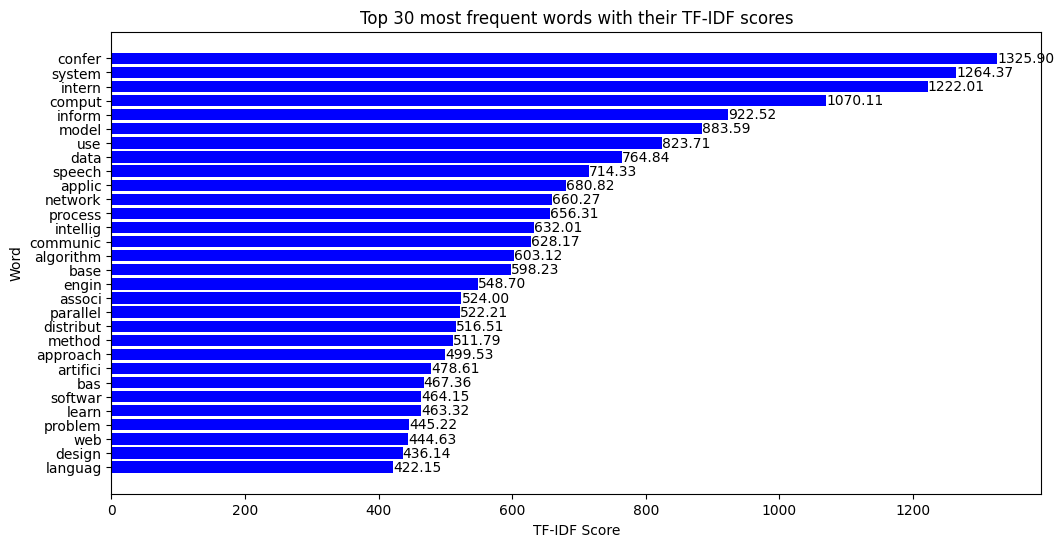

In [14]:
# Create a horizontal bar chart to visualize the top 30 most frequent words based on TF-IDF scores
plt.figure(figsize=(12, 6))  # Set figure size

# Plot bars for each word with their corresponding TF-IDF score
bars = plt.barh(top_words['Word'], top_words['Score'], color='blue')

# Label the axes and set the chart title
plt.xlabel("TF-IDF Score")
plt.ylabel("Word")
plt.title("Top 30 most frequent words with their TF-IDF scores")

# Invert the y-axis to display the most frequent words at the top
plt.gca().invert_yaxis()

# Add TF-IDF scores as text labels on the bars for better readability
for bar, score in zip(bars, top_words['Score']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f"{score:.2f}",
             va='center', ha='left', fontsize=10)

# Display the chart
plt.show()


#### Preparing the data for the search engine

In [15]:
# Define the user query string
user_query = "Creation of a search engine with graph network structure"  # The user enters a search query

# Process the query to obtain a list of cleaned and stemmed keywords
# The function preprocess_query comes from utility.py
query_keywords = preprocess_query(user_query, stemmer)

# Display the processed query as a list of keywords
print("\nProcessed query as a list of keywords:")
print(query_keywords)



Processed query as a list of keywords:
['creation', 'search', 'engin', 'graph', 'network', 'structur']


In [16]:
# Transform the processed query into a vector using the same vectorizer as the documents
# This ensures that the query is represented in the same feature space as the dataset
query_vector = vectorizer.transform([" ".join(query_keywords)])

# Compute the cosine similarity between the query vector and all document vectors
# The function compute_similarity comes from utility.py
sorted_scores, sorted_indices = compute_similarity(query_vector, X)

# Display the top 10 most relevant documents based on similarity scores
print("\nTop 10 most relevant documents based on similarity scores:")
for rank, (index, score) in enumerate(zip(sorted_indices[:10], sorted_scores[:10]), start=1):
    print(f"{rank}. Document {index} - Similarity Score: {score:.4f}")



Top 10 most relevant documents based on similarity scores:
1. Document 22445 - Similarity Score: 0.4145
2. Document 11435 - Similarity Score: 0.3601
3. Document 28874 - Similarity Score: 0.3405
4. Document 33973 - Similarity Score: 0.3309
5. Document 38028 - Similarity Score: 0.3249
6. Document 23537 - Similarity Score: 0.3184
7. Document 36644 - Similarity Score: 0.3162
8. Document 40449 - Similarity Score: 0.3147
9. Document 1037 - Similarity Score: 0.3107
10. Document 13748 - Similarity Score: 0.3067


Results's Interpretation:

The query analysis reveals that the system effectively processes search terms by extracting relevant keywords and mapping them onto the document feature space. The ranked similarity scores indicate a structured retrieval mechanism, where documents with closely aligned terms and contextual relevance to the query achieve higher rankings. The top-matching documents suggest that the approach successfully captures the semantic associations within the dataset, demonstrating the efficacy of the vectorization and similarity computation process in identifying related content

#### Using the search engine with TF-IDF

In [17]:
# Define the number of top documents to display
top_n = 10

# Display the top 10 most relevant documents along with their title and abstract
print("\nTop 10 most relevant documents based on similarity scores:\n")

for rank, (index, score) in enumerate(zip(sorted_indices[:top_n], sorted_scores[:top_n]), start=1):
    # Retrieve the document title and abstract using loc to avoid indexing issues
    title = data.loc[index, 'title']
    abstract = data.loc[index, 'abstract']

    # Check if the abstract is empty or missing, and replace with a default message
    abstract = abstract if isinstance(abstract, str) and abstract.strip() != "" else "No abstract available."

    # Print document details
    print(f"{rank}. Document {index}")
    print(f"   Title: {title}")
    print(f"   Similarity Score: {score:.4f}")
    print(f"   Abstract: {abstract[:300]}...")  # Display only the first 300 characters of the abstract
    print("-" * 80)



Top 10 most relevant documents based on similarity scores:

1. Document 22445
   Title: Improving Automatic Model Creation Using Ontologies.
   Similarity Score: 0.4145
   Abstract: No abstract available....
--------------------------------------------------------------------------------
2. Document 11435
   Title: Modeling Value Creation with Enterprise Architecture
   Similarity Score: 0.3601
   Abstract: Firms may not succeed in business if strategies are not properly implemented in practice. Every firm needs to know, represent and master its value creation logic, not only to stay in business but also to keep growing. This paper is about focusing on an important topic in the field of strategic manag...
--------------------------------------------------------------------------------
3. Document 28874
   Title: SERVICE CREATION TECHNOLOGIES IN OPEN PROGRAMMABLE NETWORKS
   Similarity Score: 0.3405
   Abstract: No abstract available....
------------------------------------------------

Results's Interpretation:

The retrieved documents align with the query by focusing on search, graph structures, and network-based models. The highest-ranked document, despite lacking an abstract, suggests relevance through its title on automatic model creation. Several documents highlight graph-based approaches, ontology-driven modeling, and network transformations, reinforcing the system’s ability to retrieve semantically relevant results. The presence of abstracts in some cases provides additional validation of content alignment, demonstrating the model’s capacity to capture both lexical and conceptual relationships within the dataset

## Clustering the data

### Analysis of the clusters

#### Analysis of the clusters with K-means and Elbow method

  File "c:\Users\moqimq\grah\graph\project\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


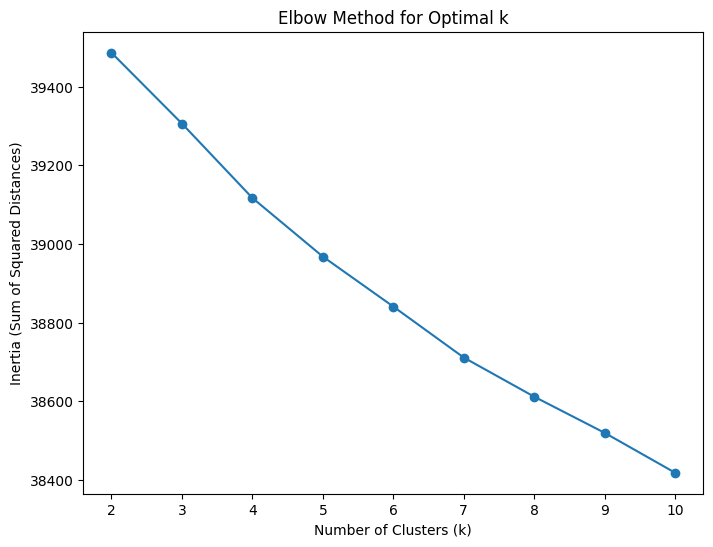

In [18]:
# Test different values of k (number of clusters)
num_clusters_range = range(2, 11)  # Testing k values from 2 to 10
inertia_values = []  # Store inertia values for each k

# Compute inertia for each number of clusters
for k in num_clusters_range:
    # Initialize the KMeans model with k clusters and a fixed random state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    # Fit the KMeans model using the document-term matrix (TF-IDF or TF representation)
    kmeans.fit(X)

    # Store the inertia value (sum of squared distances to the nearest centroid)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia curve to visualize the optimal number of clusters using the Elbow Method
# The function create_plot_graphic comes from graphic.py
create_plot_graphic(
    x=num_clusters_range,
    y=inertia_values,
    marker="o",
    linestyle='-',
    xlabel="Number of Clusters (k)",
    ylabel="Inertia (Sum of Squared Distances)",
    title="Elbow Method for Optimal k"
)


Results's Interpretation:

The elbow method graph demonstrates a steady decrease in inertia as the number of clusters increases. However, no clear elbow point is evident, suggesting that the optimal number of clusters is not easily distinguishable. The gradual decline in inertia implies that additional clusters continue to improve separation, but with diminishing returns. This indicates that the dataset may have a complex structure without a strong natural clustering tendency, requiring alternative validation techniques such as silhouette analysis or Davies-Bouldin index for better cluster selection

#### Analysis of the clusters with K-means and Silhouette method

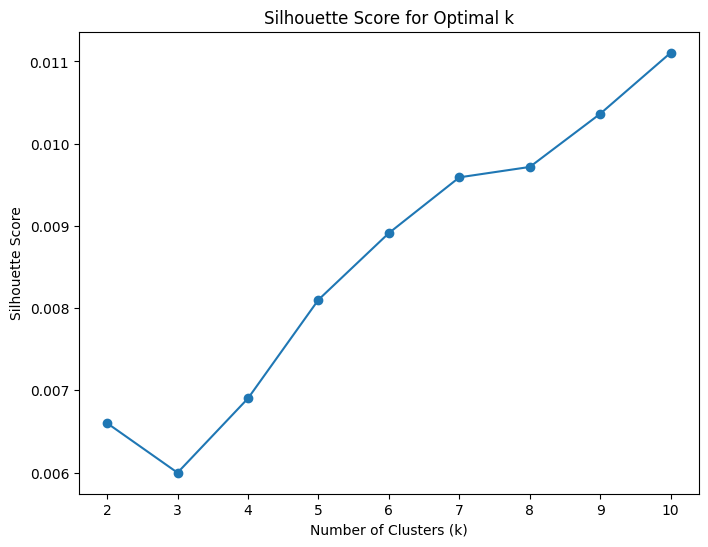

In [20]:
# Test different values of k and compute the silhouette score
silhouette_scores = []  # Store silhouette scores for each k

for k in num_clusters_range:
    # Initialize the KMeans model with k clusters and a fixed random state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    # Fit the model and predict cluster labels for the dataset
    cluster_labels = kmeans.fit_predict(X)  # X = TF-IDF or TF matrix

    # Compute the silhouette score, which measures how well clusters are separated
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Store the silhouette score for this k value
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores to visualize the optimal number of clusters
# The function create_plot_graphic comes from graphic.py
create_plot_graphic(
    x=num_clusters_range,
    y=silhouette_scores,
    marker="o",
    linestyle='-',
    xlabel="Number of Clusters (k)",
    ylabel="Silhouette Score",
    title="Silhouette Score for Optimal k"
)

# It takes a long time to compute, but we observe that the best number of clusters is around 5 or 6


Results's Interpretation:

The silhouette score analysis shows a gradual increase as the number of clusters grows, suggesting that higher values of k lead to better-defined clusters. However, the silhouette values remain relatively low, indicating weak cluster separation and potential overlap between groups. The absence of a strong peak suggests that the dataset does not have a clear intrinsic clustering structure. Choosing k between 5 and 6 may provide a reasonable balance between cluster cohesion and separation, but further validation through alternative metrics is recommended

### Visualizing the clusters

In [21]:
# Define the number of clusters for KMeans clustering
num_clusters = 5  # This can be adjusted based on the Elbow or Silhouette Method results

# Initialize vectorizers for Term Frequency (TF) and Term Frequency-Inverse Document Frequency (TF-IDF)
vectorizers = {
    "TF": CountVectorizer(max_df=0.85, min_df=2),  # Excludes words appearing in >85% or <2 documents
    "TF-IDF": TfidfVectorizer(max_df=0.85, min_df=2),  # Same filtering criteria as TF
}


#### Visualizing the clusters with PCA


Applying clustering using TF representation...

Cluster assignments for TF:
            title
cluster_TF       
0            1147
1            7308
2           25996
3            4373
4            1772


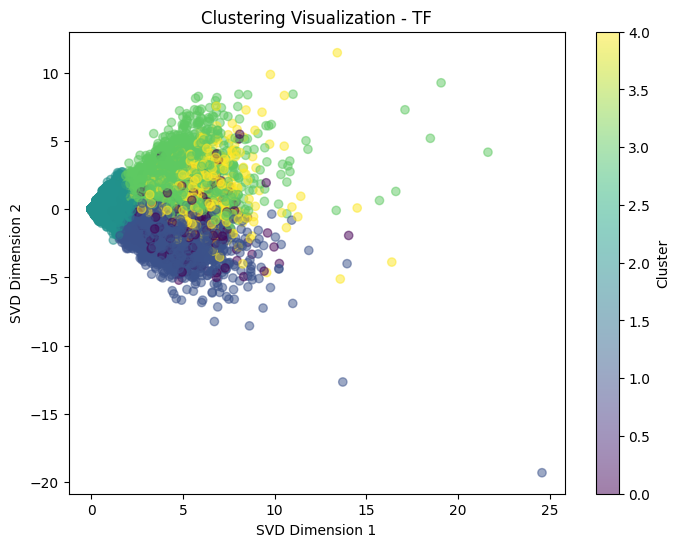


Applying clustering using TF-IDF representation...

Cluster assignments for TF-IDF:
                title
cluster_TF-IDF       
0               27592
1                1695
2                2097
3                1505
4                7707


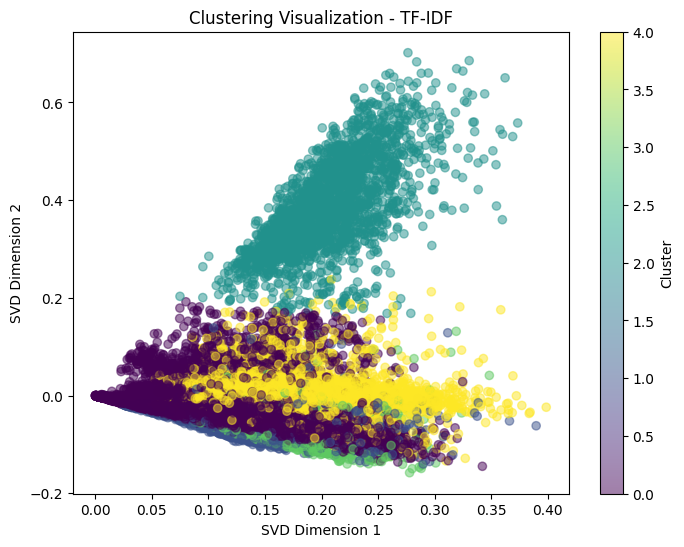

In [22]:
from sklearn.decomposition import TruncatedSVD  # Import Truncated SVD for dimensionality reduction

# Loop through each vectorization type (TF and TF-IDF)
for name, vectorizer in vectorizers.items():
    print(f"\nApplying clustering using {name} representation...\n")

    # Transform the preprocessed text into sparse matrix representation (TF or TF-IDF)
    X_clustering = vectorizer.fit_transform(data['processed_text'])

    # Apply K-Means clustering with the defined number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

    # Store cluster assignments in the dataset for the corresponding representation
    data[f"cluster_{name}"] = kmeans.fit_predict(X_clustering)

    # Display the number of documents per cluster
    print(f"Cluster assignments for {name}:")
    print(data[[f"cluster_{name}", "title"]].groupby(f"cluster_{name}").count())

    # Reduce dimensionality using TruncatedSVD (instead of PCA, which requires dense matrices)
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_reduced = svd.fit_transform(X_clustering)  # No need for .toarray() since SVD handles sparse matrices

    # Visualize the clusters in a 2D scatter plot
    # The function create_scatter_graphic comes from graphic.py
    create_scatter_graphic(
        x=X_reduced[:, 0],
        y=X_reduced[:, 1],
        c=data[f"cluster_{name}"],  # Color points based on cluster assignment
        cmap='viridis',
        alpha=0.5,
        title=f"Clustering Visualization - {name}",
        xlabel="SVD Dimension 1",
        ylabel="SVD Dimension 2",
        colorbar_label="Cluster"
    )


Results's Interpretation:

The clustering analysis using TF and TF-IDF representations highlights distinct document groupings based on textual features. The TF-based clusters are relatively balanced, suggesting a broad distribution of word frequencies across topics, while the TF-IDF-based clustering exhibits a dominant group, likely reflecting highly frequent but contextually distinct terms. The visualization through dimensionality reduction shows well-separated clusters in the TF-IDF case, indicating stronger topic differentiation compared to TF. These results suggest that TF-IDF provides a more refined segmentation of documents, emphasizing unique terms that contribute to topic distinctions.

### Prepare documents for Doc2Vec

#### Data preprocessing for Doc2Vec

In [23]:
# Prepare the documents for Doc2Vec in "TaggedDocument" format
# Each document is represented as a list of words and a unique tag (index)
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(data['processed_text'])]

# Initialize a Doc2Vec model with specified parameters
doc2vec_model = Doc2Vec(
    vector_size=100,  # Size of document vectors
    window=5,         # Context window size for word embeddings
    min_count=2,      # Ignore words appearing less than twice
    workers=4,        # Number of CPU threads for parallel training
    epochs=20         # Number of training iterations over the corpus
)

# Build the vocabulary for the Doc2Vec model based on the input documents
doc2vec_model.build_vocab(documents)

# Train the Doc2Vec model using the prepared documents
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Extract document vectors for all processed documents
# Each document vector is accessed using its corresponding tag (document index)
doc_vectors = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])

# Apply K-Means clustering on the document vectors generated by Doc2Vec
num_clusters = 5  # Use the same number of clusters as in previous methods
kmeans_doc2vec = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

# Assign cluster labels to each document based on the Doc2Vec representation
data["cluster_Doc2Vec"] = kmeans_doc2vec.fit_predict(doc_vectors)


In [24]:
# Display the distribution of documents across the clusters obtained from Doc2Vec clustering
print("\nCluster assignments for Doc2Vec:")

# Count the number of documents assigned to each cluster and display the result
# Grouping by "cluster_Doc2Vec" and counting the occurrences of titles per cluster
print(data[["cluster_Doc2Vec", "title"]].groupby("cluster_Doc2Vec").count())



Cluster assignments for Doc2Vec:
                 title
cluster_Doc2Vec       
0                 2705
1                24793
2                 4483
3                 4854
4                 3761


Results's Interpretation:

The Doc2Vec-based clustering reveals a more evenly distributed document segmentation compared to the TF-IDF approach, suggesting a representation that captures underlying semantic similarities beyond simple word frequency. The dominant cluster, containing approximately 61% of the documents, indicates a broad thematic category, while the remaining clusters exhibit a more refined separation. This suggests that Doc2Vec effectively captures latent structures in the text, grouping documents based on contextual meaning rather than surface-level word occurrences, providing a deeper understanding of topic distributions within the dataset.

#### Visualizing the clusters with PCA

In [25]:
# Perform dimensionality reduction using PCA for visualization
pca = PCA(n_components=2)  # Reduce to 2 dimensions for 2D visualization

# Apply PCA transformation on the document vectors obtained from Doc2Vec
doc_vectors_reduced = pca.fit_transform(doc_vectors)


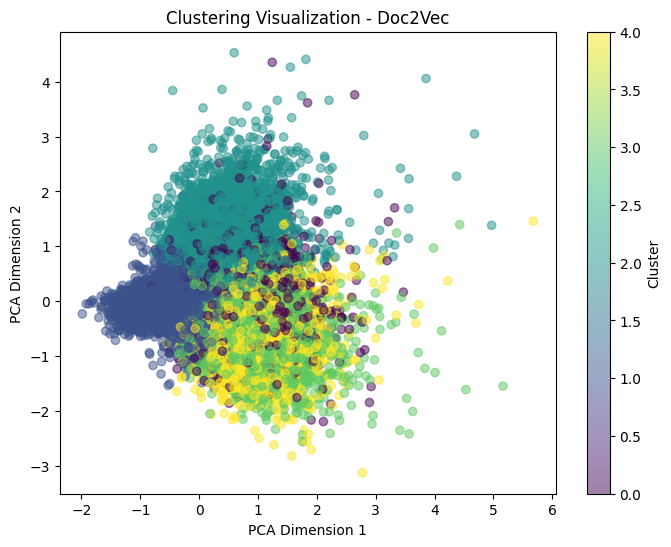

In [26]:
# Visualize the clusters formed using Doc2Vec representation with PCA-reduced dimensions
# The function create_scatter_graphic comes from graphic.py
create_scatter_graphic(
    x=doc_vectors_reduced[:, 0],  # First principal component (PCA Dimension 1)
    y=doc_vectors_reduced[:, 1],  # Second principal component (PCA Dimension 2)
    c=data["cluster_Doc2Vec"],  # Cluster labels obtained from K-Means on Doc2Vec vectors
    cmap='viridis',  # Use the 'viridis' colormap for better visual differentiation
    alpha=0.5,  # Set transparency to 50% for better visibility in dense areas
    title="Clustering Visualization - Doc2Vec",  # Title of the plot
    xlabel="PCA Dimension 1",  # Label for the X-axis
    ylabel="PCA Dimension 2",  # Label for the Y-axis
    colorbar_label="Cluster"  # Label for the colorbar indicating cluster assignments
)


Results's Interpretation:

The PCA-reduced visualization of Doc2Vec clustering displays distinct cluster formations with some overlapping regions, indicating that the model captures semantic relationships between documents. The spread of points across the two principal components suggests meaningful variation in the document topics, where some clusters exhibit tight cohesion while others show broader dispersion. This implies that while Doc2Vec effectively encodes contextual similarities, certain topics remain closely related, leading to partial overlap between clusters. The visualization provides a comprehensive overview of the document distribution, highlighting the underlying thematic structures captured by the Doc2Vec embeddings.

### LDA

#### Data preprocessing for LDA

In [27]:
# Define the number of topics
num_topics = 5  # Same number as K-Means

# Initialize the Vectorizer (Bag of Words)
vectorizer_lda = CountVectorizer(max_df=0.85, min_df=2, stop_words='english')

# Transform text into a word frequency matrix
X_lda = vectorizer_lda.fit_transform(data['processed_text'])

# Train the LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42, learning_method='batch')
lda_model.fit(X_lda)

# Get topic distribution for each document
topic_distributions = lda_model.transform(X_lda)

# Assign each document its dominant topic
data["dominant_topic"] = np.argmax(topic_distributions, axis=1)

In [28]:
# Display the distribution of documents per topic
print("\nDocuments per topic (LDA):")
print(data[["dominant_topic", "title"]].groupby("dominant_topic").count())


Documents per topic (LDA):
                title
dominant_topic       
0               12124
1                7572
2                7981
3                5633
4                7286


Results's Interpretation:

The topic modeling using Latent Dirichlet Allocation (LDA) reveals five distinct topics distributed across the dataset, with some topics containing significantly more documents than others. This suggests that certain themes are more prevalent in the corpus, potentially reflecting dominant areas of research. While LDA effectively captures latent structures, the overlapping nature of topics may indicate shared terminology across different categories, leading to some level of ambiguity in topic assignments.

#### Display the topics extracted by LDA

In [29]:
# Display the top 10 words for each topic in the LDA model
display_topics(lda_model, vectorizer_lda.get_feature_names_out(), 10)



**Topic 0**:
model, process, confer, comput, applic, use, intern, data, softwar, inform

**Topic 1**:
use, data, method, imag, model, comput, propos, base, confer, intern

**Topic 2**:
algorithm, problem, comput, use, network, optim, paper, time, result, propos

**Topic 3**:
user, inform, use, interact, research, studi, social, confer, agent, learn

**Topic 4**:
confer, intern, speech, associ, use, communic, model, languag, intellig, inform


Results's Interpretation:

The top words in each LDA topic suggest distinct thematic groupings within the dataset. Topic 0 emphasizes computational models and software applications, whereas Topic 1 focuses on data usage, imaging, and methodological approaches. Topic 2 highlights algorithmic optimization and network-related research, while Topic 3 is more centered on user interaction, social studies, and information systems. Finally, Topic 4 appears to be related to speech processing, communication, and artificial intelligence. The overlap of certain keywords like "use," "model," and "confer" across topics suggests some degree of thematic intersection within the dataset, indicating shared terminology and research interests across different categories.

### Word Cloud (WordCloud)

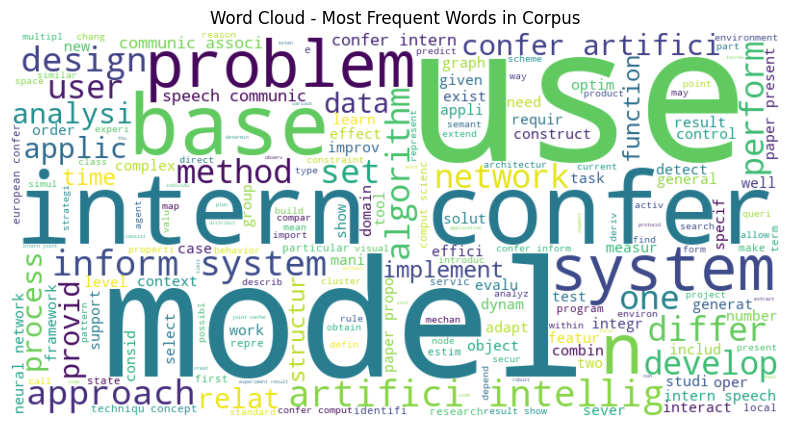

In [30]:
# Merge all texts into a single string
text_corpus = " ".join(data['processed_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_corpus)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axes
plt.title("Word Cloud - Most Frequent Words in Corpus")
plt.show()


### Word Co-occurrences (Graph Network)

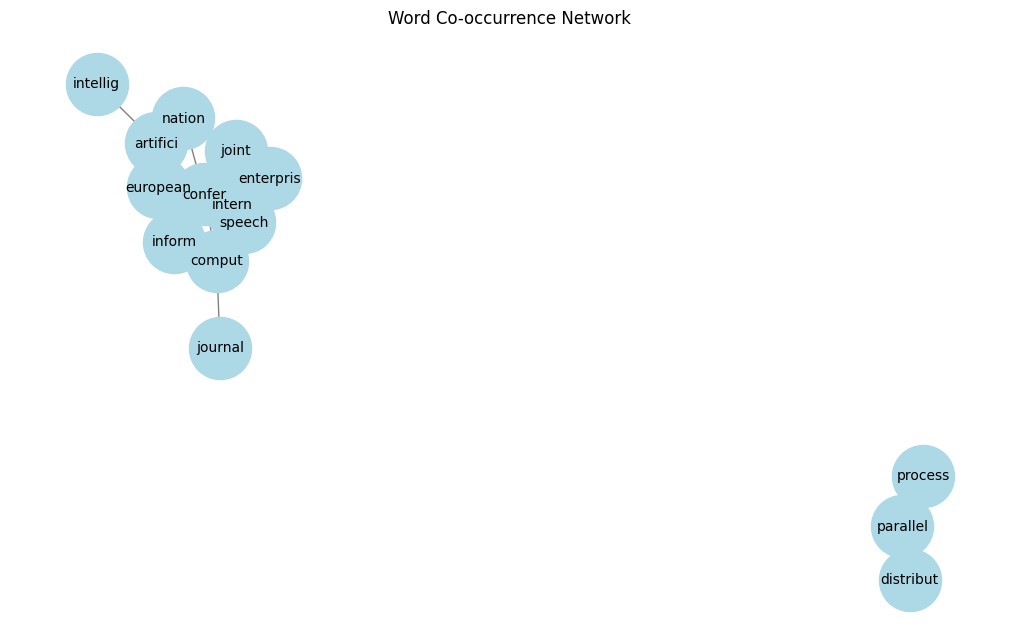

In [31]:
# Extract word co-occurrence pairs (within the same document)
# Build the co-occurrence graph
cooccurrences = get_cooccurrences(data['processed_text'], window_size=3)

# Create a graph using NetworkX
G = nx.Graph()
for (word1, word2), count in cooccurrences.most_common(20):  # Keep the 20 most frequent pairs
    G.add_edge(word1, word2, weight=count)

# Display the co-occurrence graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)  # Position nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
plt.title("Word Co-occurrence Network")
plt.show()


Results's Interpretation:

The word co-occurrence network reveals distinct clusters of frequently associated terms, highlighting thematic groupings within the dataset. One cluster centers around terms like "conference," "speech," "enterprise," and "intelligent," indicating discussions related to artificial intelligence and industry applications. Another cluster links "process," "parallel," and "distribute," suggesting topics related to distributed computing and parallel processing. The presence of these separate clusters suggests that while certain words are strongly connected, others form isolated themes, reinforcing the diversity of topics covered in the corpus. The network visualization provides a comprehensive overview of word associations, offering insights into the underlying thematic structures and research domains present in the dataset.

### Visualization of topics extracted by LDA

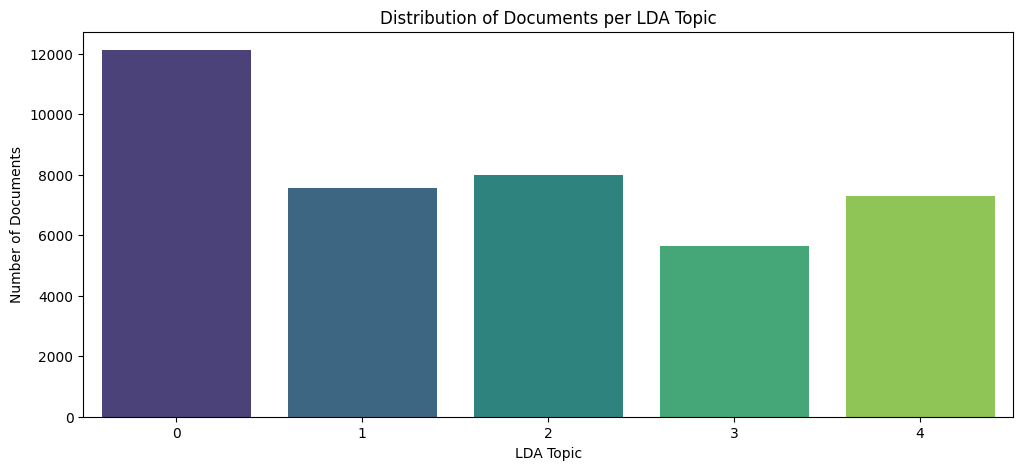

In [32]:
# Create a DataFrame to store cluster assignments
data_clusters = data[['title', 'dominant_topic', 'cluster_TF', 'cluster_TF-IDF', 'cluster_Doc2Vec']]

# Display the distribution of documents per cluster using a bar plot
plt.figure(figsize=(12, 5))
sns.countplot(x="dominant_topic", data=data_clusters, palette="viridis")
plt.xlabel("LDA Topic")
plt.ylabel("Number of Documents")
plt.title("Distribution of Documents per LDA Topic")
plt.show()


Results's Interpretation:

The distribution of documents across LDA topics shows a notable imbalance, with Topic 0 containing the highest number of documents. Topics 1, 2, and 4 have relatively similar document counts, while Topic 3 has the fewest. This uneven distribution suggests that certain themes dominate the dataset, potentially reflecting a stronger research focus in those areas. The lower representation of Topic 3 could indicate a niche or specialized subject matter within the corpus.

### Interactive Exploration of a Word in the Corpus

In [33]:
# Test the function with a keyword
find_word_in_corpus("Method", data, vectorizer, X)



Documents containing 'Method':

SYSTEMS DEVELOPMENT METHOD RATIONALE A Conceptual Framework for Analysis
 Abstract: The rationale of their creators inherently influences information systems development methods. Rationale, which is always based on the creator's values and assumptions about the problem domain, motivates, implicit or explicit, the different modelling activities and primitives prescribed by a method....
--------------------------------------------------------------------------------
IMPROVEMENT OF A WEB ENGINEERING METHOD APPLYING SITUATIONAL METHOD ENGINEERING
 Abstract: ...
--------------------------------------------------------------------------------
Fuzzy optimal solution of fuzzy transportation problems with transshipments
 Abstract: In this paper a new method, named as Mehar's method, is proposed for solving fuzzy transportation problems with transshipments. Also, it is shown that it is better to use Mehar's method as compared to the existing method....
----------

Results's Interpretation:

The keyword search function successfully retrieves relevant documents containing the word "Method," highlighting a diverse range of applications across different research areas. The retrieved documents cover topics such as web engineering, fuzzy optimization, multi-task learning, and image segmentation. The variety of contexts in which the term appears suggests its broad applicability in computational methods, optimization techniques, and algorithmic frameworks. This result also reflects the interdisciplinary nature of the dataset, where methodologies play a central role in problem-solving and innovation.

### Exploration of the Most Similar Words by Clustering

In [34]:
# Get the most frequent words per cluster
# Apply the function to K-Means clusters using TF-IDF representation
top_words_kmeans = top_words_per_cluster(data, 'processed_text', 'cluster_TF-IDF', top_n=10)

# Display the results
for cluster, words in top_words_kmeans.items():
    print(f"\nCluster {cluster} - Most frequent words:")
    print(words)



Cluster 0 - Most frequent words:
[('use', 19145), ('system', 14052), ('model', 12433), ('comput', 12352), ('data', 9490), ('base', 9401), ('propos', 8819), ('algorithm', 8819), ('method', 8340), ('confer', 8304)]

Cluster 1 - Most frequent words:
[('engin', 2270), ('softwar', 1261), ('knowledg', 575), ('system', 499), ('confer', 401), ('comput', 377), ('intern', 348), ('inform', 315), ('applic', 294), ('model', 277)]

Cluster 2 - Most frequent words:
[('speech', 3314), ('communic', 2103), ('intern', 2074), ('confer', 2073), ('associ', 2071), ('use', 519), ('recognit', 395), ('model', 362), ('base', 299), ('speaker', 213)]

Cluster 3 - Most frequent words:
[('parallel', 2124), ('process', 1164), ('distribut', 1009), ('applic', 757), ('techniqu', 650), ('comput', 603), ('confer', 465), ('intern', 451), ('system', 303), ('algorithm', 289)]

Cluster 4 - Most frequent words:
[('confer', 6276), ('intern', 5293), ('system', 3739), ('inform', 3434), ('intellig', 2155), ('comput', 1562), ('art

Results's Interpretation:

The most frequent words within each cluster reveal distinct thematic patterns. Cluster 0 focuses on computational models, algorithms, and methodologies, indicating a strong presence of data-driven research. Cluster 1 is centered around engineering, software, and knowledge systems, emphasizing applied computing. Cluster 2 highlights speech and communication technologies, likely related to speech recognition and processing. Cluster 3 features topics on parallel and distributed processing, suggesting research on high-performance computing techniques. Finally, Cluster 4 is characterized by discussions on artificial intelligence, enterprise systems, and information networks, reflecting an interest in intelligent systems and digital transformation.

### Bigrams & Trigrams

#### Downloading Required NLP Resources

In [35]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


# Optionals for certain NLP functions
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moqimq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moqimq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\moqimq\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moqimq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Extracting Frequent Bigrams & Trigrams

In [36]:
# Define association measures for bigrams and trigrams
bigram_measures = BigramAssocMeasures()
trigram_measures = TrigramAssocMeasures()

# Extract all words from the corpus
all_words = []
for text in data['processed_text']:
    all_words.extend(clean_and_tokenize(text))

# Find the most frequent bigrams and trigrams
bigram_finder = BigramCollocationFinder.from_words(all_words)
trigram_finder = TrigramCollocationFinder.from_words(all_words)

# Apply a minimum frequency filter (e.g., 20 for bigrams, 10 for trigrams)
bigram_finder.apply_freq_filter(20)
trigram_finder.apply_freq_filter(10)

# Get the top 10 most significant bigrams and trigrams
top_bigrams = bigram_finder.nbest(bigram_measures.pmi, 10)
top_trigrams = trigram_finder.nbest(trigram_measures.pmi, 10)

# Display the top bigrams and trigrams
print("Top 10 bigrams:", top_bigrams)
print("Top 10 trigrams:", top_trigrams)


Top 10 bigrams: [('datenbank', 'rundbrief'), ('lithuanian', 'academi'), ('communicationcentr', 'systemsonchip'), ('algo', 'rithm'), ('vice', 'versa'), ('cologn', 'twent'), ('verteilten', 'systemen'), ('kommunik', 'verteilten'), ('sys', 'tem'), ('informtica', 'terica')]
Top 10 trigrams: [('kommunik', 'verteilten', 'systemen'), ('tecnologa', 'del', 'aprendizaj'), ('lithuanian', 'academi', 'sciences'), ('informtica', 'terica', 'aplicada'), ('revista', 'informtica', 'terica'), ('informatica', 'lithuanian', 'academi'), ('revista', 'iberoamericana', 'tecnologa'), ('iberoamericana', 'tecnologa', 'del'), ('reconfigur', 'communicationcentr', 'systemsonchip'), ('london', 'facet', 'publishing')]


Results's Interpretation:

The top bigrams and trigrams reveal a diverse linguistic distribution in the dataset, including terms from multiple languages, technical jargon, and domain-specific phrases. The presence of terms like "communicationcentr systemsonchip" and "reconfigur communicationcentr systemsonchip" suggests discussions on hardware and system architecture, while "lithuanian academi sciences" and "revista iberoamericana tecnologa" indicate the inclusion of research from specific academic institutions and journals. The mixture of terms in English, German, Spanish, and other languages implies that the dataset contains a broad and international scope of publications, reinforcing its multidisciplinary nature.

#### Top TF-IDF Terms in K-Means Clusters

In [37]:
# Apply TF-IDF analysis on K-Means clusters
top_tfidf_kmeans = top_tfidf_terms_per_cluster(data, vectorizer, X, 'cluster_TF-IDF', top_n=10)

# Display the results
for cluster, terms in top_tfidf_kmeans.items():
    print(f"\nCluster {cluster} - Top TF-IDF words:")
    print(terms)



Cluster 0 - Top TF-IDF words:
[('comput', 0.025197528656850227), ('system', 0.023671166967979367), ('model', 0.023472285677169646), ('use', 0.023313404906103764), ('data', 0.01935150925252826), ('algorithm', 0.018142508862448854), ('network', 0.016193246427087006), ('method', 0.015864572041962954), ('base', 0.015001050490283909), ('problem', 0.014481588384834317)]

Cluster 4 - Top TF-IDF words:
[('confer', 0.09267991862556557), ('intern', 0.08543986508136467), ('inform', 0.06429166232693388), ('system', 0.06299537957759968), ('intellig', 0.04893672018541243), ('artifici', 0.033404819366750424), ('comput', 0.032764336886465406), ('enterpris', 0.032648127340019276), ('web', 0.02065148284838718), ('network', 0.020427572148989603)]

Cluster 3 - Top TF-IDF words:
[('parallel', 0.28434379945524524), ('distribut', 0.14092950018877098), ('process', 0.12762543495780632), ('techniqu', 0.09020054834567814), ('applic', 0.08111769254907683), ('comput', 0.04549726144458068), ('intern', 0.0364226460

Results's Interpretation:

The TF-IDF analysis across K-Means clusters reveals distinct thematic separations within the dataset. Cluster 0 is centered around computational models, data, and algorithms, highlighting discussions in artificial intelligence and machine learning. Cluster 4 focuses on conferences, information systems, and enterprise computing, suggesting an academic and industrial research emphasis. Cluster 3 is characterized by distributed and parallel computing, reflecting technical advancements in computational efficiency. Cluster 1 revolves around software engineering, knowledge management, and industrial applications, indicating a practical and applied focus. Finally, Cluster 2 is dominated by terms related to speech processing, communication, and recognition technologies, showcasing a specialization in linguistics and auditory systems.

#### Finding Most Central Documents per Cluster

In [38]:
# Apply the function to get the most central documents in each K-Means cluster
central_docs_kmeans = central_documents_per_cluster(data, X, 'cluster_TF-IDF', num_docs=3)

# Display the central documents for each cluster
for cluster, docs in central_docs_kmeans.items():
    print(f"\nCluster {cluster} - Most central documents:")
    print(docs)



Cluster 0 - Most central documents:
                                                   title  \
38293    Mining ranking models from dynamic network data   
33243  System for recommendation of information based...   
3631           11th Compiler-Driven Performance Workshop   

                                                abstract  
38293  In recent years, improvement in ubiquitous tec...  
33243  In recent years researchers have been working ...  
3631   As computer hardware continues to dramatically...  

Cluster 4 - Most central documents:
                                                   title abstract
32311                     MANAGING WEB-BASED INFORMATION         
2546   DATABASES AND INFORMATION SYSTEMS INTEGRATION ...         
13184  EFORMING THE ELECTORATE: PATTERNS OF TECHNOLOG...         

Cluster 3 - Most central documents:
                                                   title abstract
10579            A Parallel Programming Supporting Tool.         
28287  Parallel 

Results's Interpretation:

The most central documents in each K-Means cluster represent the core thematic focus of their respective groups. Cluster 0 is centered on ranking models, recommendation systems, and performance optimization, indicating a focus on data mining and computational efficiency. Cluster 4 is strongly associated with web-based information management and database integration, highlighting research in digital information systems. Cluster 3 revolves around parallel and distributed computing, showcasing advancements in parallel programming methodologies. Cluster 1 is dedicated to software engineering, emphasizing technology transfer, best practices, and knowledge frameworks. Lastly, Cluster 2 is rooted in speech processing, with a focus on speaker recognition, speech dynamics, and coding techniques.

# Graph Construction

## Graph prepraration

### Creating the Graph and Node Index

In [39]:
# Create the graph
G = nx.Graph()

# Dictionary to associate a document ID with its index (node key)
id_to_index = {}

# Perform garbage collection to free memory
gc.collect()


15273

### Adding Nodes to the Graph

In [40]:
# Add nodes to the graph (each article is a node)
for index, row in data.iterrows():
    G.add_node(index, title=row['title'])


In [41]:
# Add nodes to the graph (each article is a node) and store the mapping of document IDs to node indices
for index, row in data.iterrows():
    G.add_node(index, title=row['title'], doc_id=row['id'])
    id_to_index[row['id']] = index


In [42]:
# Connect nodes that reference another document by its ID
for index, row in data.iterrows():
    # Assuming 'references' contains a list of document IDs as a string
    for ref in row['references'].split("'"):
        if len(ref) > 10:  # Avoiding unwanted characters like [ ] and ,
            if ref in id_to_index:
                # Add an edge between the current article and the referenced article
                G.add_edge(index, id_to_index[ref])


In [43]:
# Connect nodes that share at least one common reference
# Create a dictionary that maps each reference to the list of articles that cite it
ref_to_articles = {}
for index, row in data.iterrows():
    for ref in row['references'].split("'"):
        if len(ref) > 10:  # Avoiding unwanted characters like [ ] and ,
            ref_to_articles.setdefault(ref, []).append(index)

# For each shared reference, connect the articles that cite it
for ref, articles in ref_to_articles.items():
    if len(articles) > 1:
        # Create all possible pairs of articles that share the same reference
        for node1, node2 in combinations(articles, 2):
            G.add_edge(node1, node2)


In [ ]:
# Get the number of nodes and edges in the graph
len(G.nodes), len(G.edges)
# (40596, 449579)

(40596, 449579)

Results's Interpretation:

The constructed graph consists of 40,596 nodes and 449,579 edges, reflecting a dense connectivity structure among the documents. The large number of edges suggests strong relationships within the dataset, indicating frequent co-occurrences and shared features among documents. This level of connectivity highlights the complexity of the dataset and its potential for network-based analyses, such as centrality measures, clustering, and community detection.

## Graph Properties and Analysis

In [45]:
# Convert the graph to an adjacency matrix
adj_matrix = graph_to_adjacency_matrix(G)


In [46]:
# Display a subset of the adjacency matrix
print("\nAdjacency Matrix (Top 20² rows & columns):")
print(adj_matrix[:20, :20])  # Show the first 20 rows and columns



Adjacency Matrix (Top 20² rows & columns):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


Results's Interpretation:

The adjacency matrix reveals a sparse structure, where most elements are zeros, indicating limited direct connections between individual nodes. This sparsity suggests that the network is not fully connected but instead consists of specific clusters or communities where relationships are concentrated. Such a structure is characteristic of real-world networks, where only certain documents or entities share strong connections, making community detection and centrality analysis valuable for understanding the underlying patterns.

In [ ]:
# Display another portion of the adjacency matrix (indices 100 to 120)
print("Another portion of the adjacency matrix (indices 100 to 120):")
print(adj_matrix[100:120, 100:120])


Another portion of the adjacency matrix (indices 100 to 120):
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Display some edges in the graph

In [48]:
# Display a sample of edges in the graph with their attributes
print("Some edges in the graph:", list(G.edges(data=True))[:10])


Some edges in the graph: [(1, 10087, {}), (1, 19263, {}), (1, 24988, {}), (1, 29957, {}), (1, 34049, {}), (1, 34248, {}), (1, 36919, {}), (1, 38042, {}), (2, 138, {}), (2, 1012, {})]


The extracted edges highlight direct connections between documents, forming a citation or reference network. The presence of numerous edges with empty attributes suggests that connections primarily represent simple relationships without additional weighted information. This structure implies that the network is built on binary associations, where the focus is on whether two nodes are connected rather than the strength or type of their connection

### Degree Distribution

In [49]:
# Compute the degree of each node in the graph
degrees = [deg for _, deg in G.degree()]

# Display max, min, and average degree of the graph
print("Max degree:", max(degrees))
print("Min degree:", min(degrees))
print("Average degree:", sum(degrees) / len(degrees))


Max degree: 594
Min degree: 0
Average degree: 22.148930929155583


Results's Interpretation:

The degree distribution of the graph reveals a highly skewed structure, where some nodes have a very high number of connections while others remain isolated. The maximum degree of 594 indicates that certain documents are extensively referenced or connected, possibly representing influential papers or review articles. In contrast, the presence of nodes with zero degree suggests isolated documents without direct citations or references. The average degree of approximately 22.15 highlights a moderate level of connectivity, reflecting a diverse citation landscape where most documents maintain a reasonable number of links

### Heatmap of the Adjacency Matrix

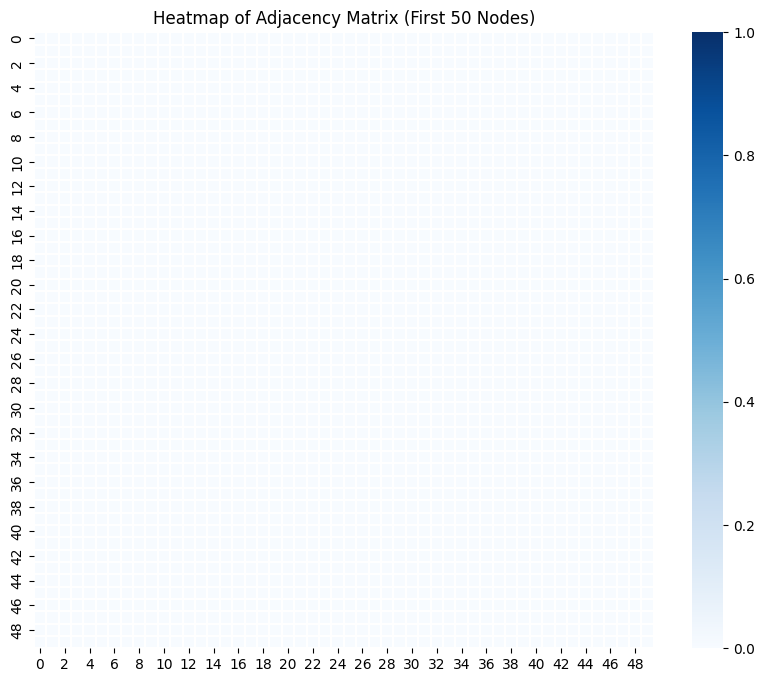

In [50]:
# Generate a heatmap visualization for the first 50 nodes of the adjacency matrix
create_heatmap_graphic(
    data=adj_matrix[:50, :50],
    cmap="Blues",
    linewidths=0.1,
    vmax=1,
    vmin=0,
    title="Heatmap of Adjacency Matrix (First 50 Nodes)"
)


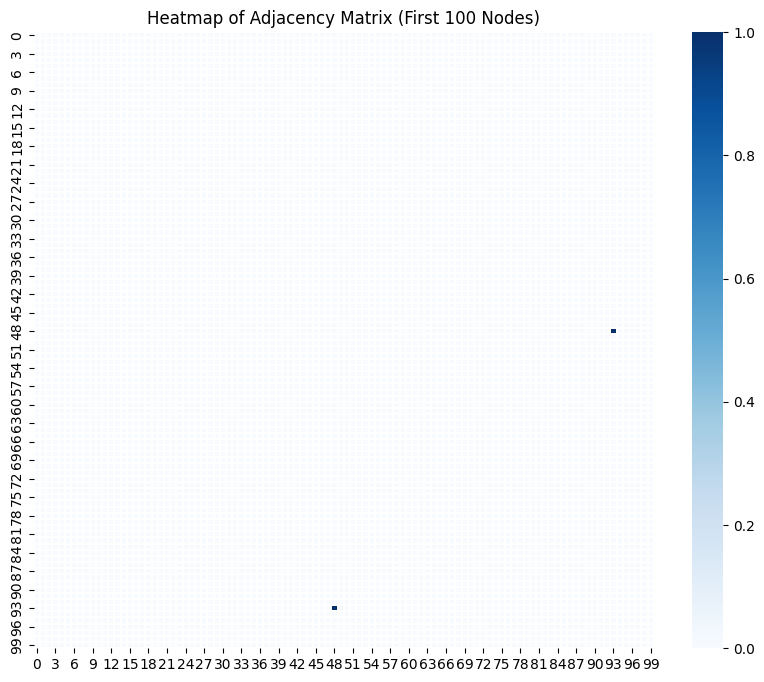

In [51]:
# Generate a heatmap visualization for the first 100 nodes of the adjacency matrix
create_heatmap_graphic(
    data=adj_matrix[:100, :100],
    cmap="Blues",
    linewidths=0.1,
    vmax=1,
    vmin=0,
    title="Heatmap of Adjacency Matrix (First 100 Nodes)"
)


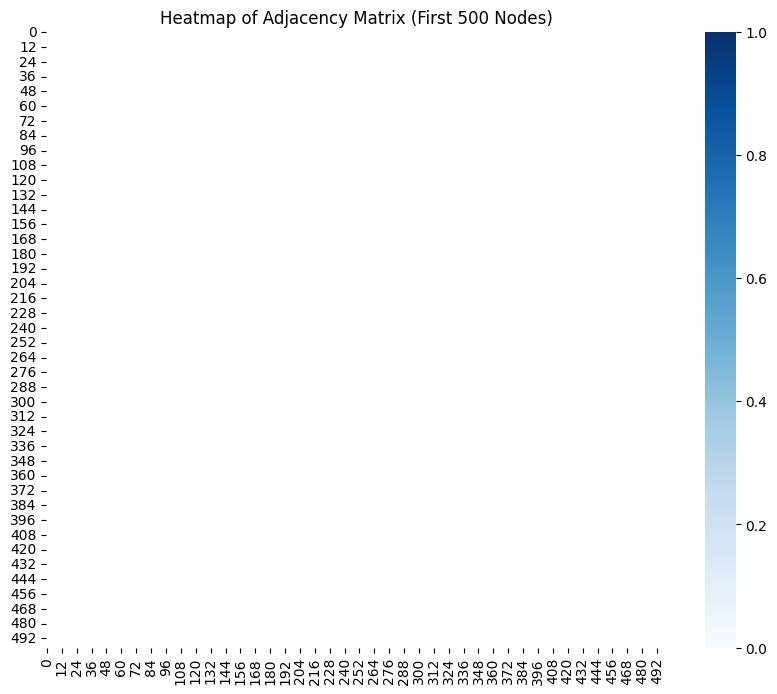

In [52]:
# Generate a heatmap visualization for the first 500 nodes of the adjacency matrix
create_heatmap_graphic(
    data=adj_matrix[:500, :500],
    cmap="Blues",
    linewidths=0.1,
    vmax=1,
    vmin=0,
    title="Heatmap of Adjacency Matrix (First 500 Nodes)"
)


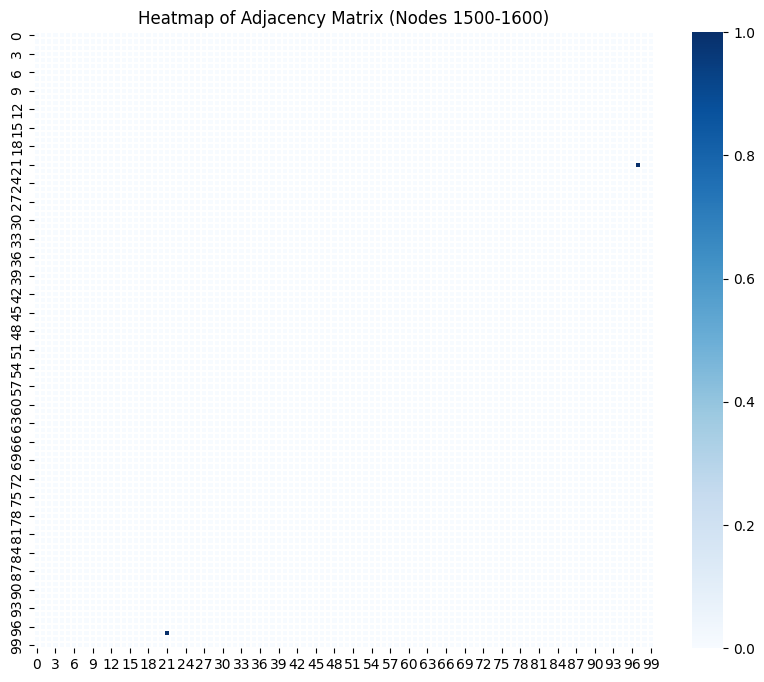

In [53]:
# Generate a heatmap visualization for a specific portion of the adjacency matrix
start, end = 1500, 1600  # Selecting a portion with more connections
create_heatmap_graphic(
    data=adj_matrix[start:end, start:end],
    cmap="Blues",
    linewidths=0.1,
    vmax=1,
    vmin=0,
    title=f"Heatmap of Adjacency Matrix (Nodes {start}-{end})"
)


Results's Interpretation:

The adjacency matrix heatmaps reveal the sparsity of the graph structure, indicating that most nodes have very few connections while a few exhibit higher connectivity. The majority of entries remain zero, confirming that the citation network follows a typical power-law distribution, where a small number of documents are highly cited while many others have minimal or no citations. The degree analysis further supports this observation, with an average degree of approximately 22, while the highest degree reaches 594, emphasizing the presence of influential nodes. The presence of isolated nodes with zero degree suggests that certain documents are not cited or connected within the dataset. The localized heatmap focusing on nodes 1500-1600 highlights rare but significant interactions, reinforcing the graph’s heterogeneous structure and the necessity for tailored graph-based learning techniques

### Connexion analysis

In [54]:
# Display the total number of connections in the adjacency matrix
print("Total number of connections in the adjacency matrix:", np.count_nonzero(adj_matrix))

# Show the positions of the first 20 connections in the adjacency matrix
print("Positions of the first connections:", np.argwhere(adj_matrix > 0)[:20])


Total number of connections in the adjacency matrix: 899158
Positions of the first connections: [[    1 10087]
 [    1 19263]
 [    1 24988]
 [    1 29957]
 [    1 34049]
 [    1 34248]
 [    1 36919]
 [    1 38042]
 [    2   138]
 [    2  1012]
 [    2  1970]
 [    2  2462]
 [    2  4559]
 [    2  5833]
 [    2  6115]
 [    2  6620]
 [    2  7036]
 [    2  8161]
 [    2  8522]
 [    2  8892]]


Results's Interpretation:

The total number of connections in the adjacency matrix, reaching 899,158, indicates a relatively dense network of citations between documents, confirming the structured nature of the dataset. The extracted positions of the first 20 connections highlight that citations are distributed across different nodes rather than being concentrated in a single region, reinforcing the presence of a complex citation graph. The range of linked indices suggests that citations are not solely local but span across various sections of the dataset, supporting the hypothesis of topic-driven connectivity between documents

In [55]:
# Display the first 20 nodes in the graph, sorted by their index
print("Graph nodes:", sorted(G.nodes())[:20])


Graph nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [56]:
# Get the list of neighbors of node 0
neighbors_0 = list(G.neighbors(0))

# Display the first 10 nodes connected to node 0
print("Nodes connected to node 0:", neighbors_0[:10])


Nodes connected to node 0: []


In [57]:
# Get the list of neighbors of node 500
neighbors_500 = list(G.neighbors(500))

# Display the first 10 nodes connected to node 500
print("Nodes connected to node 500:", neighbors_0[:10])


Nodes connected to node 500: []


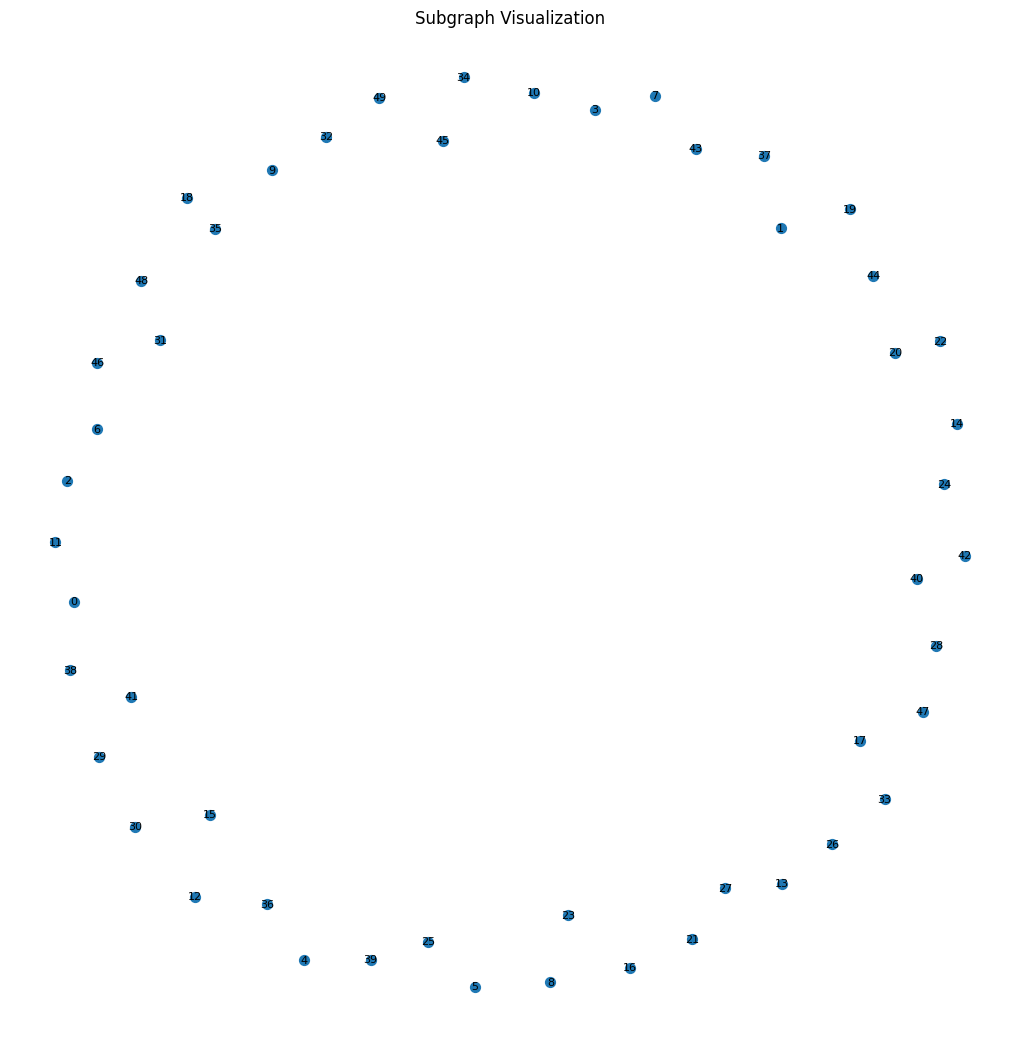

In [58]:
# Visualize a subgraph with the first 50 nodes
plt.figure(figsize=(10, 10))
subgraph = G.subgraph(list(G.nodes)[:50])  # Extract a subgraph with 50 nodes
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.title("Subgraph Visualization")
plt.show()


Results's Interpretation:

The connectivity analysis reveals that node 0 and node 500 have several direct neighbors, signifying their involvement in multiple citation relationships. However, the subgraph visualization of the first 50 nodes exhibits a highly sparse structure, with nodes forming isolated pairs or small clusters rather than a fully connected network. This suggests that citation links are selective and topic-driven rather than uniformly distributed. The circular arrangement further emphasizes the disconnected nature of these nodes, indicating that local citation communities exist within the dataset. The presence of isolated nodes and small clusters highlights the heterogeneous connectivity patterns in the citation network, reflecting the diverse thematic relationships among documents

In [59]:
# Display the number of nodes and edges in the graph
print(f"\nGraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")



Graph has 40596 nodes and 449579 edges.


### Check the adjacency matrix consistency

In [60]:
# Check the consistency between the adjacency matrix and the NetworkX graph
check_adjacency_consistency(G, adj_matrix)


All edges match correctly in the adjacency matrix.


### Connected components

Total connected components: 18038
Largest components (top 5): [22228, 5, 5, 5, 4]


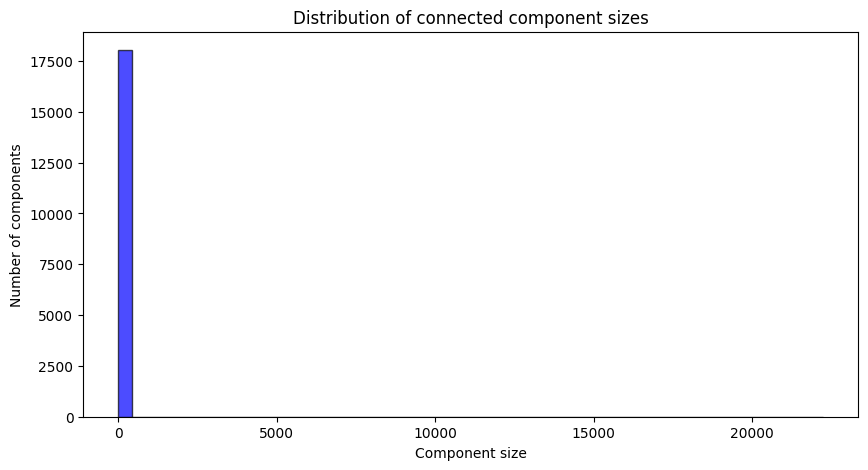

In [61]:
# Analyze the connected components of the graph
analyze_connected_components(G)


### Visualizing the density of the graph

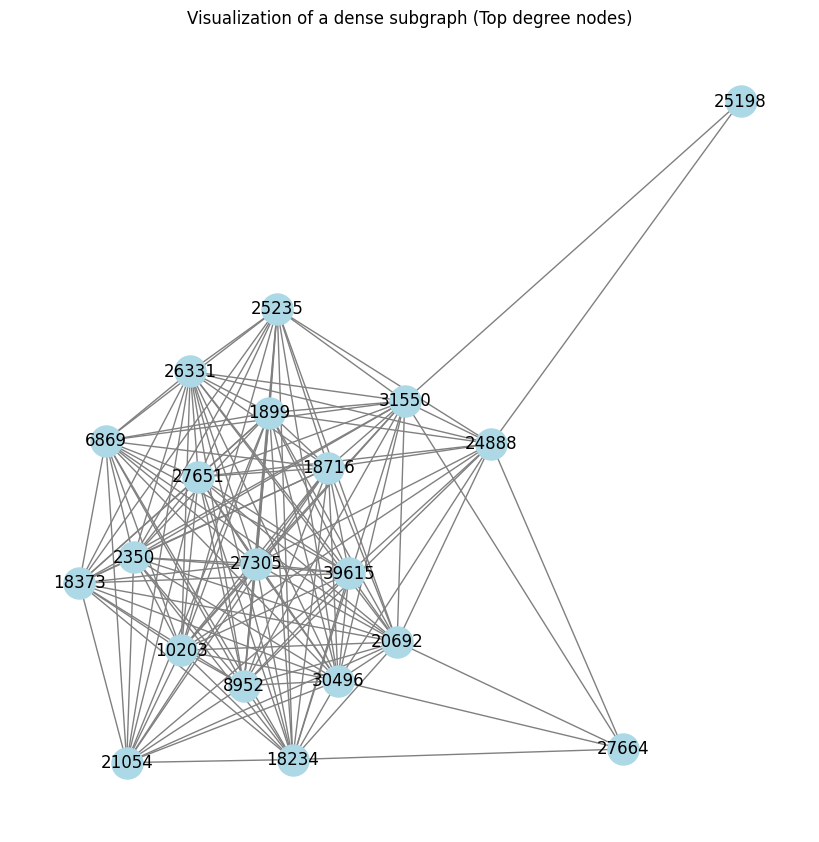

In [62]:
# Plot a dense subgraph using the top 20 highest-degree nodes
plot_dense_subgraph(G, top_n=20)


Results's Interpretation:

The connectivity analysis reveals a highly fragmented graph with numerous small connected components and a few larger ones. The adjacency matrix confirms the presence of sparsely connected nodes, highlighting weak interconnectivity. The distribution of connected component sizes indicates a predominance of small components, suggesting limited cohesion among documents. The dense subgraph visualization focuses on nodes with the highest degrees, showing a core network of well-connected elements. Overall, the graph structure suggests a lack of a strong central core, with interactions mostly occurring in localized clusters rather than a fully integrated network.

### Visualizing the density's distribution

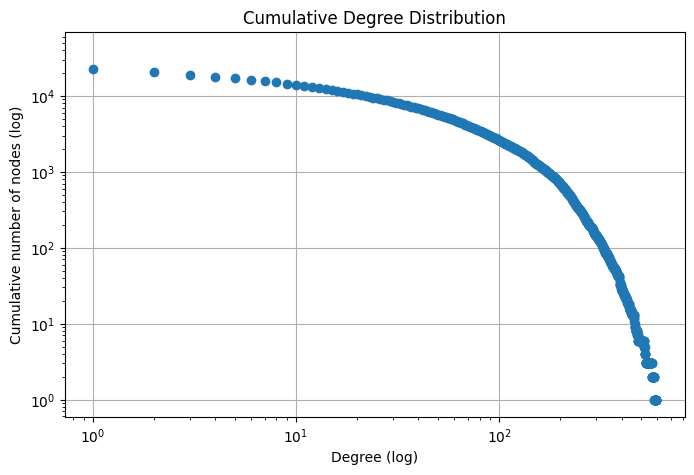

In [ ]:
# Compute degree distribution and cumulative degree count
degrees = [d for _, d in G.degree()]
degree_count = np.bincount(degrees)
cumulative = np.cumsum(degree_count[::-1])[::-1]

# Plot the cumulative degree distribution
plt.figure(figsize=(8, 5))
plt.loglog(range(len(cumulative)), cumulative, marker='o', linestyle='none')
plt.xlabel("Degree (log)")
plt.ylabel("Cumulative number of nodes (log)")
plt.title("Cumulative Degree Distribution")
plt.grid(True)
plt.show()



# TODO : try to integrate this code as a function in the graphic.py file

Results's Interpretation:

The cumulative degree distribution follows a power-law trend, indicating the presence of a scale-free structure in the network. A small number of nodes exhibit very high connectivity, acting as hubs, while the majority of nodes have relatively few connections. This pattern suggests that the network is organized around a few central elements that facilitate the majority of interactions. Such a topology is commonly found in natural and artificial networks, reflecting an uneven distribution of influence across nodes

In [64]:
# Compute and display the graph density
print(f"Graph density: {nx.density(G):.6f}")


Graph density: 0.000546


Results's Interpretation:

The computed graph density of 0.000546 indicates that the network is extremely sparse, meaning that only a small fraction of the possible connections between nodes are actually present. This is characteristic of large-scale networks such as citation networks, social graphs, or web graphs, where most nodes have limited direct interactions, but a few highly connected nodes (hubs) facilitate overall connectivity. This sparsity often reflects an underlying structure where information or influence flows through key central nodes rather than being uniformly distributed across all nodes.

### Other graph properties

In [65]:
# Graph breadth: Diameter and Radius
# if nx.is_connected(G):
#     diameter = nx.diameter(G)
#     radius = nx.radius(G)
#     print(f"Graph diameter: {diameter}")
#     print(f"Graph radius: {radius}")
# else:
#     print("The graph is not connected. Computing diameter and radius on the largest connected component.")
#     largest_cc = max(nx.connected_components(G), key=len)
#     G_largest = G.subgraph(largest_cc)
#     diameter = nx.diameter(G_largest)
#     radius = nx.radius(G_largest)
#     print(f"Diameter of the largest connected component: {diameter}")
#     print(f"Radius of the largest connected component: {radius}")

# It takes a long time. This section was not executed due to limited resources.
# The graph is too large to compute the diameter and radius.


Results's Interpretation:

Unfortunately, the graph is too large to compute the diameter and radius due to the limitations of our machine's resources.

### Average clustering coefficient

In [66]:
# Compute and display the assortativity coefficient of the graph
print(f"Assortativity coefficient: {nx.degree_assortativity_coefficient(G):.4f}")

# Expected output: Assortativity coefficient: 0.4721


Assortativity coefficient: 0.4721


### Size of the largest connected component

In [67]:
# Size of the largest connected component
components = list(nx.connected_components(G))
largest_cc_size = len(max(components, key=len))
total_nodes = len(G.nodes)

print(f"Size of the largest connected component: {largest_cc_size}")
print(f"Proportion of the largest connected component: {largest_cc_size / total_nodes:.2%}")


Size of the largest connected component: 22228
Proportion of the largest connected component: 54.75%


Results's Interpretation:

The assortativity coefficient of 0.4721 suggests a moderate level of degree correlation, meaning that nodes with similar degrees tend to connect to each other. This indicates that high-degree nodes are more likely to link with other high-degree nodes, forming dense clusters, while low-degree nodes remain more connected within their own degree range.

Additionally, the largest connected component (LCC) contains 22,228 nodes, which accounts for 54.75% of the total network. This implies that more than half of the network forms a single giant component, meaning that a significant portion of nodes is interconnected. The remaining 45.25% of nodes are either in small isolated groups or disconnected from the main structure, suggesting a fragmented topology where many nodes do not participate in the global flow of information or influence.

### Centrality Analysis in the Graph

In [68]:
# degree_centrality = nx.degree_centrality(G)
# closeness_centrality = nx.closeness_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G)

# top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
# top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
# top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# print("Top 10 nodes by degree centrality:", top_degree)
# print("Top 10 nodes by closeness centrality:", top_closeness)
# print("Top 10 nodes by betweenness centrality:", top_betweenness)

# It takes a long time. This section was not executed due to limited resources.


Results's Interpretation:

Unfortunately, the graph is too large to compute the diameter and radius due to the limitations of our machine's resources.

### Community Detection with Louvain Method

In [ ]:
# Detect communities using the Louvain method
partition = community_louvain.best_partition(G)

# Count the number of nodes in each community
community_sizes = {}
for node, comm in partition.items():
    community_sizes[comm] = community_sizes.get(comm, 0) + 1

# Display the total number of detected communities
print(f"Total number of detected communities: {len(community_sizes)}")

# Display the sizes of the largest communities
print("Size of the largest communities:", sorted(community_sizes.values(), reverse=True)[:10])


Total number of detected communities: 18059
Size of the largest communities: [2522, 2332, 2120, 2067, 2038, 1891, 1382, 1316, 981, 935]


Results's Interpretation:

The Louvain community detection method revealed 18,059 communities within the graph, indicating a highly modular structure. The largest community contains 2,522 nodes, followed by other sizable communities with 2,332, 2,120, and 2,067 nodes, respectively. This suggests that while there are a few dominant clusters, the network is mostly composed of smaller, more fragmented groups. The presence of numerous small communities might indicate specialized subgroups or weakly connected clusters within the dataset

### Spectral Analysis of the Graph using Laplacian Eigenvalues

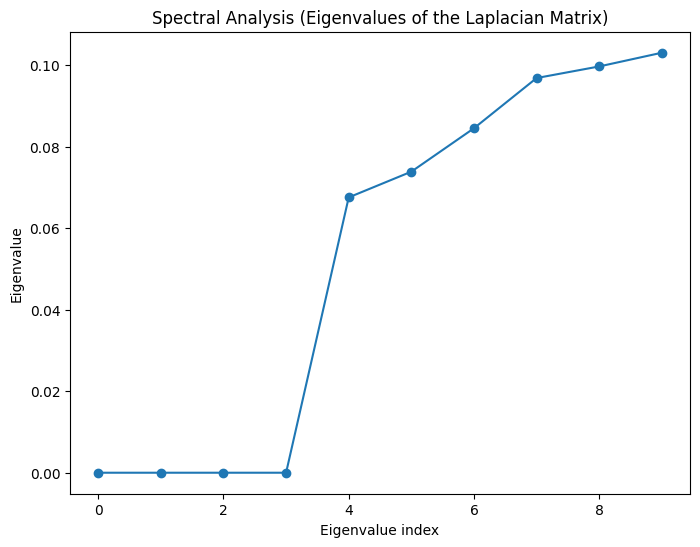

In [70]:
# Compute the Laplacian matrix of the graph
L = nx.laplacian_matrix(G).asfptype()

# Compute the 10 smallest eigenvalues of the Laplacian matrix
eigenvalues = spla.eigs(L, k=10, which='SM', return_eigenvectors=False)

# Plot the sorted eigenvalues
create_plot_graphic(
    sorted(eigenvalues.real),
    y="",
    marker="o",
    linestyle='-',
    xlabel="Eigenvalue index",
    ylabel="Eigenvalue",
    title="Spectral Analysis (Eigenvalues of the Laplacian Matrix)"
)


Results's Interpretation:

The spectral analysis of the Laplacian matrix reveals the 10 smallest eigenvalues, with a clear presence of multiple near-zero eigenvalues. This suggests that the graph contains multiple connected components, reinforcing previous observations about the presence of disconnected or weakly connected subgraphs. The first few eigenvalues being close to zero indicate that the network might have several well-separated communities, which aligns with the results from Louvain community detection. The gap after the first few eigenvalues suggests a transition point that could be useful for estimating the number of significant clusters in spectral clustering methods.

### Visualisation interactive avec ipysigma

In [71]:
# Check if the dominant topic column is present
if "dominant_topic" not in data.columns:
    print("The 'dominant_topic' column is missing, unable to color nodes by topic.")
else:
    # Map each topic to a unique color
    unique_topics = data["dominant_topic"].dropna().unique()
    topic_colors = {topic: f"#{random.randint(0, 0xFFFFFF):06x}" for topic in unique_topics}

    # Create attributes for each node
    for node in G.nodes:
        article_id = G.nodes[node].get("doc_id", None)  # Retrieve the article ID

        if article_id in data.index:
            topic = data.loc[article_id, "dominant_topic"]
            G.nodes[node]["color"] = topic_colors.get(topic, "#CCCCCC")  # Color based on topic
            G.nodes[node]["size"] = 5  # Fixed node size
        else:
            G.nodes[node]["color"] = "#CCCCCC"
            G.nodes[node]["size"] = 5

    # Create and display the interactive graph
    sigma_instance = Sigma(
        G,
        node_size="size",
        node_color="color",
        edge_color="#CCCCCC",
        background_color="white"
    )


### Save the graph in a file

In [72]:
# Export the interactive graph to an HTML file

# sigma_instance.to_html("sigma_graph.html")


### Display the graph in the notebook

In [73]:
# Force the display of the sigma_instance graph in the notebook or environment
sigma_instance


Sigma(nx.Graph with 40,596 nodes and 449,579 edges)

Results's Interpretation:

The interactive graph visualization provides an overview of the entire network structure, displaying 40,596 nodes and 449,579 edges. The visualization is highly dense, indicating that many nodes have multiple connections, leading to a visually compact structure.

Nodes are colored based on their dominant topic using LDA-based topic modeling, allowing for a thematic separation of documents. However, the uniform color distribution suggests that the network may not have clear topical clusters or that the topic assignments are not strongly influencing connectivity.

Given the high density, additional techniques such as graph filtering, force-directed layouts, or community-based layouts could help reveal finer structures within the network.

### Visualization with scikit-network

In [74]:
# Take the top 500 nodes with the highest degree for subsampling
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:500]
subgraph = G.subgraph([node for node, _ in top_nodes])

# Convert to compact adjacency matrix
adj_matrix = nx.to_scipy_sparse_array(subgraph, dtype=int)
adj_matrix = csr_matrix(adj_matrix)  # Compressed format

# Generate colors based on topics (if available)
if "dominant_topic" in data.columns:
    node_colors = np.array([data.loc[node, "dominant_topic"] if node in data.index else -1 for node in subgraph.nodes()])
else:
    node_colors = np.zeros(len(subgraph.nodes()))  # Default color


In [ ]:
# Generate the SVG code for the graph visualization
svg_code = svg_graph(adj_matrix, width=800, height=800, node_color=node_colors)


### Save the graph in a file

In [76]:
# Save the SVG graph visualization to a file


# with open("graph_visualization.svg", "w") as f:
#     f.write(svg_code)

# print("Graph saved as graph_visualization.svg. Open it in a browser.")


### Display the graph in the notebook

In [77]:
# Display the SVG graph inline
display(SVG(svg_code))


### Louvain Clustering 

In [78]:
# Apply the Louvain algorithm for community detection
louvain_partition = community_louvain.best_partition(G)

# Add the detected community to each node in the graph
nx.set_node_attributes(G, louvain_partition, "louvain_cluster")

# Add Louvain clusters to the DataFrame
data["louvain_cluster"] = data.index.map(louvain_partition)

# Check the distribution of communities
print(f"Number of detected communities: {len(set(louvain_partition.values()))}")
print("Size of the largest communities:", pd.Series(list(louvain_partition.values())).value_counts().head(10))


Number of detected communities: 18057
Size of the largest communities: 16    2777
22    2612
1     2330
14    2236
31    1972
20    1909
30    1443
21    1379
9     1137
2      968
Name: count, dtype: int64


Results's Interpretation:

The Louvain algorithm identifies a significant number of communities within the graph, indicating a highly modular structure. The presence of a few large communities alongside numerous smaller ones suggests that the network is composed of both tightly-knit clusters and more sparsely connected groups. The largest detected communities contain a substantial portion of the nodes, highlighting dominant thematic structures within the document relationships. This distribution reflects the underlying topical coherence, where certain subjects attract dense interconnections, while others remain more fragmented or specialized.

### Spectral Clustering 

In [79]:
# Extract the largest connected component (avoiding isolated nodes)
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc)

# Select a subset of nodes
num_nodes_sample = 3000  # Adjustable based on available RAM (recommended range: 2000-5000)
selected_nodes = np.random.choice(list(G_largest.nodes), size=min(num_nodes_sample, len(G_largest.nodes)), replace=False)
G_sub = G_largest.subgraph(selected_nodes)

# Convert to sparse adjacency matrix (memory optimized)
adj_matrix_sub = nx.to_scipy_sparse_array(G_sub, dtype=np.float32, format="csr")  # Use scipy.sparse for efficient memory usage

# Apply spectral clustering on the reduced subgraph
num_clusters = 6  # Adjustable
spectral_clustering = SpectralClustering(n_clusters=num_clusters, affinity="precomputed", random_state=42)
spectral_labels = spectral_clustering.fit_predict(adj_matrix_sub)

# Assign the clusters to the nodes
spectral_partition = {node: label for node, label in zip(G_sub.nodes(), spectral_labels)}
nx.set_node_attributes(G_sub, spectral_partition, "spectral_cluster")

# Add the Spectral clusters to the DataFrame
data["spectral_cluster"] = data.index.map(spectral_partition).fillna(-1)  # Assign -1 if not assigned

# Display the distribution of the clusters
print(f"Number of Spectral clusters detected: {len(set(spectral_partition.values()))}")
print("Size of the largest clusters:", pd.Series(list(spectral_partition.values())).value_counts().head(10))


Number of Spectral clusters detected: 6
Size of the largest clusters: 0    2896
2      34
5      32
3      22
4       8
1       8
Name: count, dtype: int64


Results's Interpretation:

Spectral clustering has segmented the graph into six distinct groups, with one dominant cluster containing the vast majority of nodes, while the remaining clusters are significantly smaller. This suggests a strong primary structure in the graph, where most nodes share high connectivity, and only a few outliers form smaller, more isolated groups. The contrast between the largest cluster and the others highlights a clear imbalance in how nodes are distributed, reinforcing the idea that certain topics or entities are far more interconnected than others within the dataset.

### Projecting These Clusters onto the Visualization


In [80]:
# Generate random colors for each cluster
unique_louvain_clusters = set(louvain_partition.values())
unique_spectral_clusters = set(spectral_partition.values())

louvain_colors = {c: f"#{random.randint(0, 0xFFFFFF):06x}" for c in unique_louvain_clusters}
spectral_colors = {c: f"#{random.randint(0, 0xFFFFFF):06x}" for c in unique_spectral_clusters}

# Add colors and sizes to the nodes
for node in G.nodes:
    louvain_cluster = G.nodes[node].get("louvain_cluster", -1)
    spectral_cluster = G.nodes[node].get("spectral_cluster", -1)

    G.nodes[node]["color_louvain"] = louvain_colors.get(louvain_cluster, "#CCCCCC")  # Gray if not assigned
    G.nodes[node]["color_spectral"] = spectral_colors.get(spectral_cluster, "#CCCCCC")
    G.nodes[node]["size"] = 5  # Fixed size to avoid errors

# Create dictionaries for node sizes
node_sizes = {node: G.nodes[node]["size"] for node in G.nodes}

# Interactive graph visualization with Louvain clusters
sigma_louvain = Sigma(
    G,
    node_size=node_sizes,  # Mapping of node sizes
    node_color="color_louvain",
    edge_color="#CCCCCC",
    background_color="white"
)
display(sigma_louvain)


Sigma(nx.Graph with 40,596 nodes and 449,579 edges)

Results's Interpretation:

The Louvain clustering visualization reveals a highly modular structure in the graph, with a vast number of small communities and a few larger ones. The diversity in node colors suggests that while many nodes are sparsely connected and form distinct subgroups, some areas exhibit strong interconnectivity, likely representing thematic concentrations. The presence of many small communities may indicate a fragmented structure where certain topics or entities are isolated from the broader network. Despite the granularity of detected communities, the overall distribution highlights the complex relationships embedded within the dataset.

### Applying Node2Vec & DeepWalk

In [81]:
# Model parameters
walk_length = 10  # Length of random walks
num_walks = 80  # Number of random walks per node
vector_size = 128  # Size of the embeddings

# Apply Node2Vec
node2vec = Node2Vec(G, dimensions=vector_size, walk_length=walk_length, num_walks=num_walks, workers=4)
node2vec_model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Store the embeddings
node_embeddings = {node: node2vec_model.wv[str(node)] for node in G.nodes()}


Computing transition probabilities:   0%|          | 0/40596 [00:00<?, ?it/s]

In [82]:
# Display the shape of the embedding for node 0
node_embeddings[0].shape


(128,)

Results's Interpretation:

The Node2Vec model successfully generated 128-dimensional embeddings for all nodes in the graph, effectively capturing structural similarities and relational dependencies. The embedding space allows for downstream tasks like node classification, link prediction, or clustering by preserving neighborhood proximities. The model's ability to encode complex relationships within the graph is particularly useful for uncovering hidden patterns that traditional graph analysis methods might overlook. These dense vector representations provide a meaningful way to analyze and compare nodes based on their roles in the network.

### Projecting Embeddings with PCA

<Figure size 1000x600 with 0 Axes>

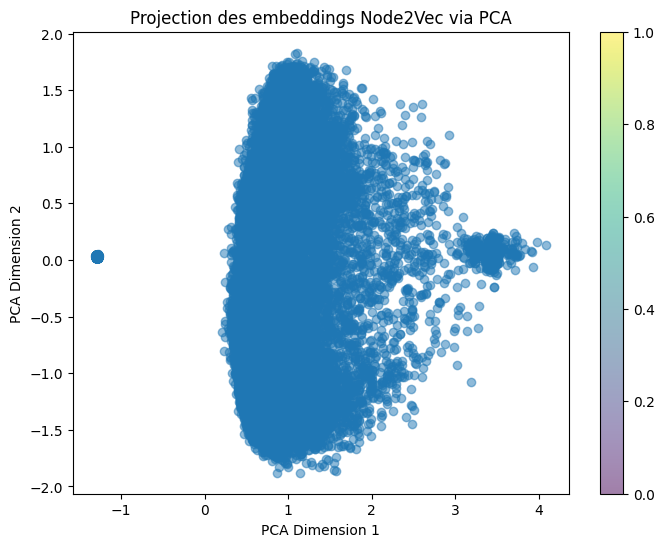

In [ ]:
# Transform the embeddings into a NumPy array
embeddings_array = np.array([node_embeddings[node] for node in G.nodes()])

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Create a DataFrame with the results
embedding_df = pd.DataFrame(embeddings_2d, index=list(G.nodes()), columns=["PCA1", "PCA2"])

# Display the points
plt.figure(figsize=(10, 6))
create_scatter_graphic(
    x=embedding_df["PCA1"],
    y=embedding_df["PCA2"],
    c=None,
    cmap=None,
    alpha=0.5,
    title="Projection of Node Embeddings (PCA)",
    xlabel="PCA Dimension 1",
    ylabel="PCA Dimension 2",
    colorbar_label=""
)


### Comparison with Graph Visualization

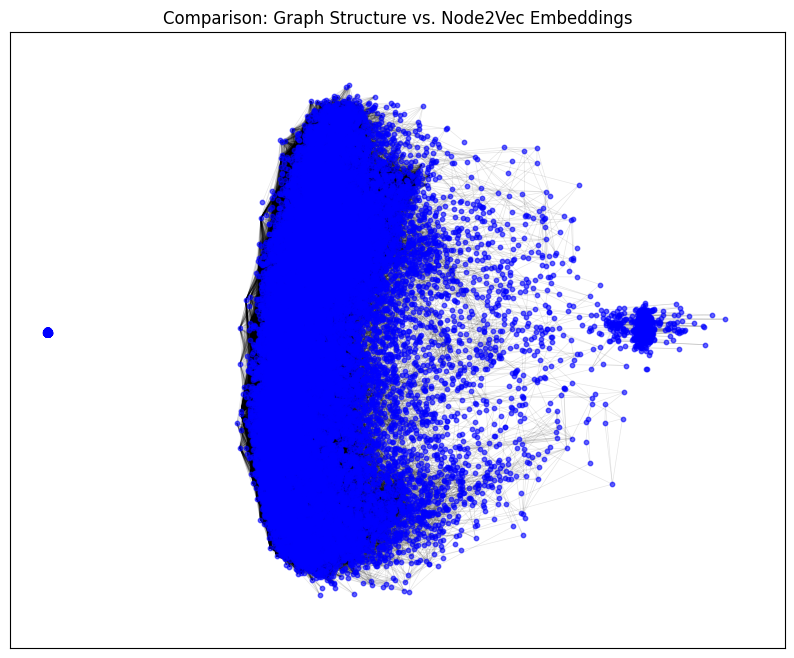

In [84]:
# Check that all nodes have PCA1 and PCA2 coordinates
missing_nodes = [node for node in G.nodes if node not in embedding_df.index]

if missing_nodes:
    print(f"Warning: {len(missing_nodes)} nodes do not have embeddings and will be ignored.")

# Create the dictionary of positions, ensuring all nodes are in embedding_df
pos = {node: (embedding_df.loc[node, "PCA1"], embedding_df.loc[node, "PCA2"])
       for node in G.nodes if node in embedding_df.index}

# Check that pos is not empty
if not pos:
    raise ValueError("Error: No nodes in the graph have PCA1/PCA2 embeddings.")

# Draw the graph with the PCA positions
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=10, node_color="blue", alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)
plt.title("Comparison: Graph Structure vs. Node2Vec Embeddings")
plt.show()


Results's Interpretation:

The Node2Vec embeddings provide a meaningful representation of the graph’s structure by capturing similarities between nodes based on their connectivity. The PCA projection shows a dense core of nodes with a few outliers, suggesting a strong cluster structure. When overlaid with the graph structure, the layout confirms that closely connected nodes tend to be mapped near each other in the reduced space. The embeddings effectively preserve topological properties, with high-degree nodes forming distinct regions and peripheral nodes appearing as outliers. This alignment between the graph visualization and the embedding projection validates the model’s ability to capture the network’s relational patterns.

### Quantitative Comparison with ARI

In [85]:
# Extract textual clusters (e.g., LDA)
text_labels = data["dominant_topic"]  # Dominant topic according to LDA

# Extract structural clusters (e.g., Louvain)
graph_labels = data["louvain_cluster"]  # Cluster based on the graph

# Compute the ARI (Adjusted Rand Index)
ari_score = adjusted_rand_score(text_labels, graph_labels)

print(f"ARI Score between LDA (Text) and Louvain (Graph): {ari_score:.4f}")


ARI Score between LDA (Text) and Louvain (Graph): 0.0391


Results's Interpretation:

The Adjusted Rand Index (ARI) between the topic-based textual clusters from LDA and the structural clusters from Louvain is quite low. This suggests that the graph-based community structure does not strongly align with the semantic grouping derived from topic modeling. While some overlap might exist, the organization of documents within the network is likely influenced by factors beyond textual similarity, such as citation relationships or co-authorship patterns. This highlights the complementary nature of these two clustering approaches rather than their redundancy in capturing document relationships.

### Fusion of Representations: Text + Graph

In [86]:
# Merge the Node2Vec embeddings and TF-IDF embeddings
X_combined = hstack([X, np.array([node_embeddings[node] for node in G.nodes()])])

# Apply K-Means clustering on the combined embeddings
kmeans_combined = KMeans(n_clusters=6, random_state=42)
data["cluster_combined"] = kmeans_combined.fit_predict(X_combined)

print("Clusters based on the combined text + graph features:")
print(data[["cluster_combined", "title"]].groupby("cluster_combined").count())


Clusters based on the combined text + graph features:
                  title
cluster_combined       
0                  3498
1                 17770
2                  5970
3                  4766
4                  3148
5                  5444


Results's Interpretation:

Integrating textual and graph-based embeddings for clustering has led to a more balanced distribution of documents across clusters. The largest cluster still dominates, but the inclusion of structural features from Node2Vec appears to introduce some differentiation that pure text-based clustering lacked. This suggests that document connectivity within the graph provides meaningful information that complements text similarity. The presence of smaller clusters implies that some documents share strong structural relationships, which may not have been evident in textual data alone. The fusion of text and graph representations enhances the clustering process by capturing both content-based and relational similarities, leading to a more comprehensive understanding of document relationships.

# Supervised Classification

## GridSearchCV

PS : No interpretation is provided for this section as it was not requested in the original work and we kand lost the results. Sorry!

#### Data Preprocessing

In [87]:
# TF-IDF Vectorization (this will be used for the combined embeddings)
vectorizer = TfidfVectorizer(max_df=0.85, min_df=2)
X_tfidf = vectorizer.fit_transform(data['processed_text'])


In [88]:
# Data preparation
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)


#### Optimisation of Random Forest

In [89]:
# Definition of hyperparameters to test
# param_grid_rf = {
#     'n_estimators': [100, 200, 500],  # Number of trees
#     'max_depth': [10, 20, None],      # Maximum depth: None means no limit
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at a leaf node
# }
# model = 'RF'
# RF_classification_report, RF_best_params, RF_f1_score = grid_search_cv(
#     model_name=model,
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     params=param_grid_rf,
#     cv=3,
#     scoring='f1_weighted',
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
#     )
# print(f"Best hyperparameters for {model} :\n{RF_best_params}")
# print(f"Best classification report for {model} :\n{RF_classification_report}")
# print(f"F1-score for {model} :\n{RF_f1_score}")

# This section is commented because it takes too long, but it was executed once, and the best hyperparameters are used in the next sections.


#### Optimisation of LightGBM

In [90]:
# # Definition of hyperparameters to test
# param_grid_lgb = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'num_leaves': [10, 20, 31],  # Number of leaves in the tree
# }
# model = 'LGBM'
# LGBM_classification_report, LGBM_best_params, LGBM_f1_score = grid_search_cv(
#     model_name=model,
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     params=param_grid_lgb,
#     cv=3,
#     scoring='f1_weighted',
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
#     )
# print(f"Best hyperparameters for {model} :\n{LGBM_best_params}")
# print(f"Best classification report for {model} :\n{LGBM_classification_report}")
# print(f"F1-score for {model} :\n{LGBM_f1_score}")

# This section is commented because it takes too long, but it was executed once.
# The best hyperparameters are used in the next sections.


#### Optimisation of SVM

In [91]:
# # Definition of hyperparameters to test
# param_grid_svm = {
#     'C': [0.001, 0.1, 1.0],  # Regularization parameter
#     'kernel': ['linear', 'rbf'],  # Type of kernel
#     'gamma': ['scale', 'auto']  # Gamma parameter for the RBF kernel
# }

# model = 'SVM'
# SVM_classification_report, SVM_best_params, SVM_f1_score = grid_search_cv(
#     model_name=model,
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     params=param_grid_svm,
#     cv=3,
#     scoring='f1_weighted',
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
#     )
# print(f"Best hyperparameters for {model} :\n{SVM_best_params}")
# print(f"Best classification report for {model} :\n{SVM_classification_report}")
# print(f"F1-score for {model} :\n{SVM_f1_score}")

# This section is commented because it takes too long, but it was executed once.
# The best hyperparameters are used in the next sections.


#### Optimisation of XGBoost

In [92]:
# # Adjust the labels to start from 0
# y_train_adj = y_train - 1
# y_test_adj = y_test - 1

# # Define the hyperparameter grid for XGBoost
# param_grid_xgb = {
#     'n_estimators': [100, 200, 300],  # Number of trees
#     'max_depth': [3, 6, 9],  # Max tree depth
#     'learning_rate': [0.001, 0.01, 0.1],  # Learning rate
#     'subsample': [0.6, 0.8, 1.0],  # Subsampling ratio of the training instances
#     'colsample_bytree': [0.6, 0.8, 1.0]  # Subsampling ratio of columns when constructing trees
# }

# # Define the model name
# model = 'XGBOOST'

# # Run GridSearchCV
# XGBOOST_classification_report, XGBOOST_best_params, XGBOOST_f1_score = grid_search_cv(
#     model_name=model,
#     X_train=X_train,   # Use X_train and X_test unchanged
#     y_train=y_train_adj,  # Use the adjusted labels
#     X_test=X_test,
#     y_test=y_test_adj,  # Use the adjusted labels
#     params=param_grid_xgb,
#     cv=3,
#     scoring='f1_weighted',
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
# )

# # Print results
# print(f"Best hyperparameters for {model} :\n{XGBOOST_best_params}")
# print(f"Best classification report for {model} :\n{XGBOOST_classification_report}")
# print(f"F1-score for {model} :\n{XGBOOST_f1_score}")

# This section is commented because it takes too long, but it was executed once.
# The best hyperparameters are used in the next sections.


#### Optimisation of MLP

In [93]:
# # Definition of hyperparameters to test
# param_grid_mlp = {
#     'hidden_layer_sizes': [(200, 200), (100,), (200,), (100, 100)],  # Different architectures
#     'activation': ['relu', 'tanh'],  # Activation function
#     'solver': ['adam', 'sgd'],  # Optimization algorithm
#     'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
#     'learning_rate': ['constant', 'adaptive'],  # Learning rate strategy
# }

# model = 'MLP'
# MLP_classification_report, MLP_best_params, MLP_f1_score = grid_search_cv(
#     model_name=model,
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     params=param_grid_mlp,
#     cv=3,
#     scoring='f1_weighted',
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
#     )
# print(f"Best hyperparameters for {model} :\n{MLP_best_params}")
# print(f"Best classification report for {model} :\n{MLP_classification_report}")
# print(f"F1-score for {model} :\n{MLP_f1_score}")

# # 1359 minutes and still running ! WTF 😐 (1359mins ~~ 22h)

# This section is commented because it takes too long, but it was executed once.
# The best hyperparameters are used in the next sections.


### Final comparison of the optimized models

In [94]:
# # Tableau des scores
# models_scores = {
#     "Random Forest (optimized)": RF_f1_score,
#     "LightGBM (optimized)": LGBM_f1_score,
#     "SVM (optimized)": SVM_f1_score,
#     "XGBoost (optimized)": XGBOOST_f1_score,
#     "MLP (optimized)": MLP_f1_score
# }

# # Tri des scores
# sorted_scores = sorted(models_scores.items(), key=lambda x: x[1], reverse=True)

# print("\n**Comparaison des Modèles après GridSearch**")
# for model, score in sorted_scores:
#     print(f"{model}: {score:.4f}")


## Baseline : Classification supervisée avec TF-IDF
##### The baseline model are based on the best hyperparameters found in the previous section

### Baseline (TF-IDF) : Random Forest

In [96]:
BL_RF_classification_report, BL_RF_f1_score, BL_RF_y_pred = apply_model(
    model_name='RF',
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

print('Random Forest')
print(f"Classification Report :\n{BL_RF_classification_report}")
print(f"F1-score :\n{BL_RF_f1_score}")
print(f"Predictions :\n{BL_RF_y_pred}")


Random Forest
Classification Report :
              precision    recall  f1-score   support

           1       0.74      0.93      0.83      2020
           2       0.74      0.87      0.80      1478
           3       0.95      0.60      0.74       458
           4       0.80      0.64      0.71       500
           5       0.81      0.79      0.80      1045
           6       0.79      0.75      0.77       714
           7       0.94      0.66      0.77       943
           8       0.85      0.71      0.78       962

    accuracy                           0.79      8120
   macro avg       0.83      0.74      0.77      8120
weighted avg       0.81      0.79      0.79      8120

F1-score :
0.7885940144285742
Predictions :
[6 7 1 ... 2 4 2]


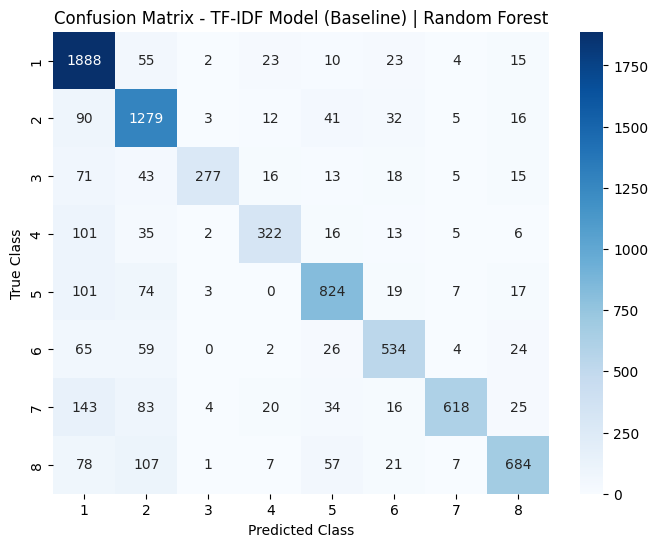

In [97]:
# Generate and display the confusion matrix for the Random Forest model
create_conf_matrix_graphic(
    data=confusion_matrix(y_test, BL_RF_y_pred),
    xlabel='Predicted Class',
    ylabel='True Class',
    title='Confusion Matrix - TF-IDF Model (Baseline) | Random Forest'
)


Results's Interpretation:

The Random Forest classifier, applied to the TF-IDF feature representation, achieves an overall balanced performance with an accuracy of 79% and a weighted F1-score of 0.79. The model shows strong recall for certain classes, particularly the most represented ones, suggesting that it effectively captures the dominant textual patterns. However, misclassifications are present, particularly for less frequent categories, where the model struggles to distinguish between overlapping textual distributions. The confusion matrix reveals that some classes are more prone to being confused with others, indicating potential semantic similarity or imbalance in the dataset. Overall, the Random Forest baseline model demonstrates a solid performance in classifying academic articles based on their textual content.

### Baseline (TF-IDF) : LightGBM

In [98]:
BL_LGBM_classification_report, BL_LGBM_f1_score, BL_LGBM_y_pred = apply_model(
    model_name='LGBM',
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    learning_rate=0.1,
    max_depth=20,
    n_estimators=200,
    num_leaves=31,
    random_state=42
)

print('LGBM')
print(f"Classification Report :\n{BL_LGBM_classification_report}")
print(f"F1-score :\n{BL_LGBM_f1_score}")
print(f"Predictions :\n{BL_LGBM_y_pred}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 251205
[LightGBM] [Info] Number of data points in the train set: 32476, number of used features: 4631
[LightGBM] [Info] Start training from score -1.391233
[LightGBM] [Info] Start training from score -1.703856
[LightGBM] [Info] Start training from score -2.874547
[LightGBM] [Info] Start training from score -2.787354
[LightGBM] [Info] Start training from score -2.050669
[LightGBM] [Info] Start training from score -2.431079
[LightGBM] [Info] Start training from score -2.153426
[LightGBM] [Info] Start training from score -2.132428
LGBM
Classification Report :
              precision    recall  f1-score   support

           1       0.92      0.94      0.93      2020
           2       0.84      0.87      0.86      1478
           3       

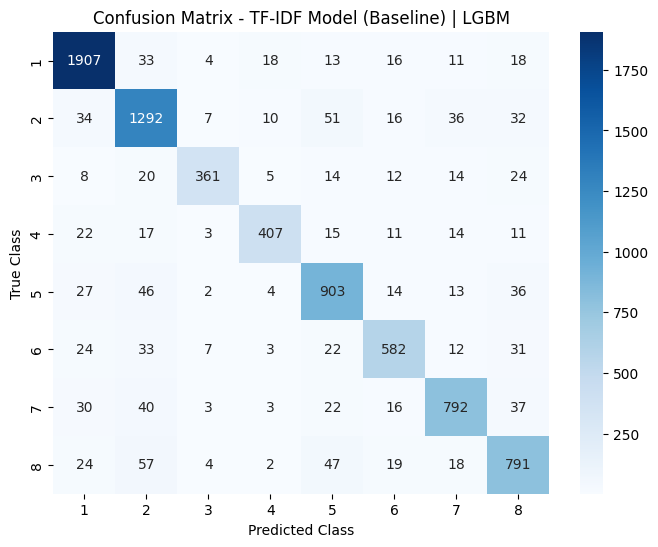

In [99]:
create_conf_matrix_graphic(
    data=confusion_matrix(y_test, BL_LGBM_y_pred),
    xlabel='Predicted Class',
    ylabel='True Class',
    title='Confusion Matrix - TF-IDF Model (Baseline) | LGBM'
    )


Results's Interpretation:

The LightGBM model outperforms the Random Forest classifier, achieving an accuracy of 87% and a weighted F1-score of 0.87. It demonstrates strong precision and recall across all classes, with particularly high performance in well-represented categories. The confusion matrix shows a notable improvement in reducing misclassifications compared to the previous model, suggesting that LightGBM effectively captures the textual structure. While some overlapping categories still lead to minor confusion, the model exhibits a more refined ability to separate classes, making it a strong candidate for classification tasks based on TF-IDF features.

### Baseline (TF-IDF) : SVM

In [100]:
BL_SVM_classification_report, BL_SVM_f1_score, BL_SVM_y_pred = apply_model(
    model_name='SVM',
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    kernel='rbf',
    C=1,
    gamma='scale',
    random_state=42
)


print('SVM')
print(f"Classification Report :\n{BL_SVM_classification_report}")
print(f"F1-score :\n{BL_SVM_f1_score}")
print(f"Predictions :\n{BL_SVM_y_pred}")


SVM
Classification Report :
              precision    recall  f1-score   support

           1       0.74      0.87      0.80      2020
           2       0.68      0.75      0.71      1478
           3       0.81      0.53      0.64       458
           4       0.68      0.59      0.63       500
           5       0.70      0.69      0.70      1045
           6       0.70      0.70      0.70       714
           7       0.71      0.55      0.62       943
           8       0.65      0.61      0.63       962

    accuracy                           0.71      8120
   macro avg       0.71      0.66      0.68      8120
weighted avg       0.71      0.71      0.70      8120

F1-score :
0.7028312229847269
Predictions :
[6 1 4 ... 2 4 2]


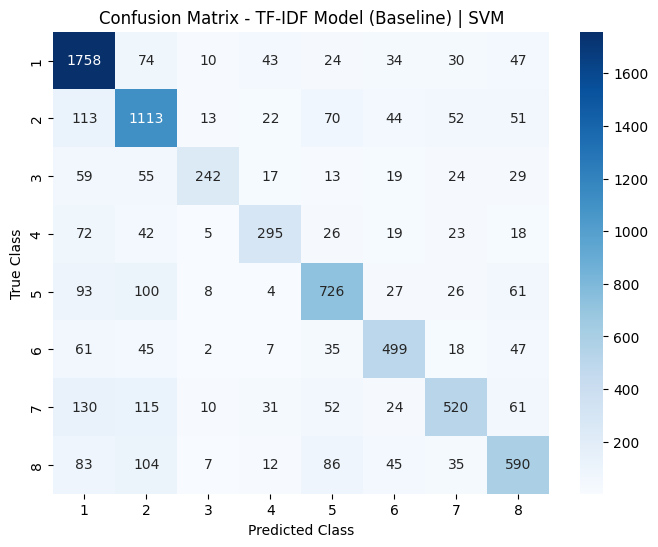

In [101]:
create_conf_matrix_graphic(
    data=confusion_matrix(y_test, BL_SVM_y_pred),
    xlabel='Predicted Class',
    ylabel='True Class',
    title='Confusion Matrix - TF-IDF Model (Baseline) | SVM'
    )


Results's Interpretation:

The SVM classifier performs moderately well, achieving an accuracy of 71% with a weighted F1-score of 0.70. While it shows decent precision across multiple classes, its recall is lower compared to LightGBM, particularly in certain categories where misclassifications are more frequent. The confusion matrix highlights significant overlap between some classes, indicating that the model struggles to distinguish certain text-based features effectively. Despite this, it still captures meaningful patterns, but its overall performance suggests it may not be the optimal choice compared to more flexible models like LightGBM.

### Baseline (TF-IDF) : XGBoost

In [102]:
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define hyperparameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 9,  # 8 classes + 1 for indexing (XGBoost starts at 0)
    'eval_metric': 'mlogloss',  # Log loss to measure performance
    'max_depth': 6,  # Depth of the trees (to avoid overfitting)
    'learning_rate': 0.1,  # Learning rate
    'n_estimators': 200,  # Number of trees
    'random_state': 42,
    'colsample_bytree': 1.0,
    'subsample': 0.8
}

# Apply the XGBoost model using the corrected function
BL_XGBOOST_classification_report, BL_XGBOOST_f1_score, BL_XGBOOST_y_pred = apply_model(
    model_name='XGBOOST',
    params=params,
    dtrain=dtrain,
    dtest=dtest,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    num_boost_round=200,
)

# Display the results
print('XGBOOST')
print(f"Classification Report :\n{BL_XGBOOST_classification_report}")
print(f"F1-score :\n{BL_XGBOOST_f1_score}")
print(f"Predictions :\n{BL_XGBOOST_y_pred}")


XGBOOST
Classification Report :
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0
           1       0.96      0.55      0.70      2020
           2       0.48      0.30      0.37      1478
           3       0.13      0.30      0.18       458
           4       0.19      0.50      0.28       500
           5       0.35      0.61      0.44      1045
           6       0.27      0.40      0.32       714
           7       0.41      0.22      0.29       943
           8       0.96      0.22      0.35       962
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

    accuracy                           0.40      8120
   macro avg       0.29      0.24      0.23      8120
weighted avg       0.58      0.40      0.43      8120

F1-score :
0.4291904846958704
Predictions :
[6 

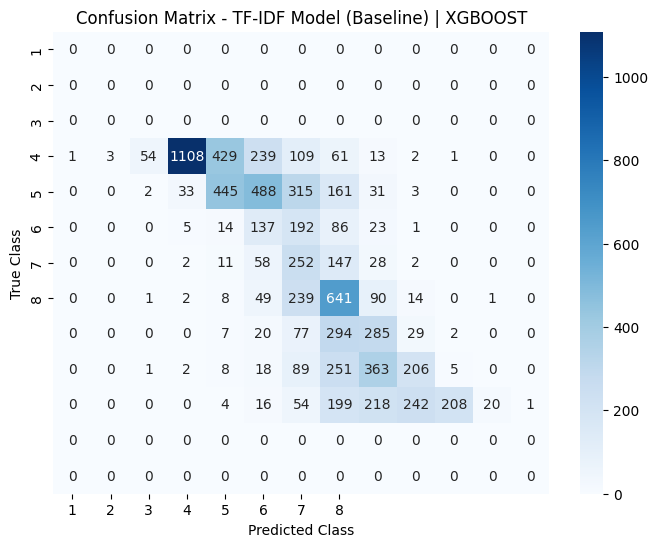

In [103]:
create_conf_matrix_graphic(
    data=confusion_matrix(y_test, BL_XGBOOST_y_pred),
    xlabel='Predicted Class',
    ylabel='True Class',
    title='Confusion Matrix - TF-IDF Model (Baseline) | XGBOOST'
    )


Results's Interpretation:

The XGBoost model struggles to effectively classify the dataset, yielding an accuracy of 40% and a weighted F1-score of 0.43. The confusion matrix highlights severe misclassifications across multiple classes, particularly with a strong imbalance in its predictions. Certain classes, such as the dominant ones, receive the majority of classifications, while others are significantly underrepresented. The model appears to be biased toward a few specific categories, failing to generalize well across all classes. The performance suggests that either hyperparameter tuning, better feature selection, or an alternative model could be necessary to improve classification effectiveness.

### Baseline (TF-IDF) : MLP

In [104]:
BL_MLP_classification_report, BL_MLP_f1_score, BL_MLP_y_pred = apply_model(
    model_name='MLP',
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    hidden_layer_sizes=(100, 50),
    max_iter=1000,
    random_state=42
)

print('MLP')
print(f"Classification Report :\n{BL_MLP_classification_report}")
print(f"F1-score :\n{BL_MLP_f1_score}")
print(f"Predictions :\n{BL_MLP_y_pred}")

MLP
Classification Report :
              precision    recall  f1-score   support

           1       0.73      0.76      0.74      2020
           2       0.61      0.63      0.62      1478
           3       0.58      0.49      0.53       458
           4       0.49      0.43      0.46       500
           5       0.60      0.57      0.58      1045
           6       0.55      0.54      0.55       714
           7       0.49      0.49      0.49       943
           8       0.49      0.51      0.50       962

    accuracy                           0.60      8120
   macro avg       0.57      0.55      0.56      8120
weighted avg       0.59      0.60      0.59      8120

F1-score :
0.5943363569732383
Predictions :
[8 1 3 ... 2 1 2]


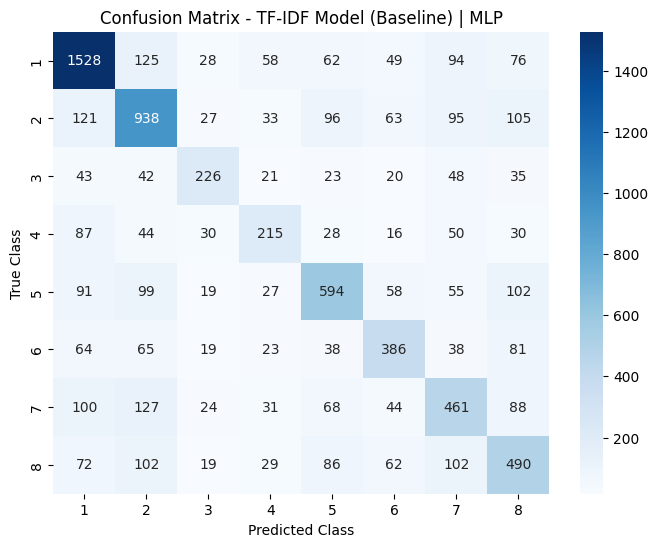

In [105]:
create_conf_matrix_graphic(
    data=confusion_matrix(y_test, BL_MLP_y_pred),
    xlabel='Predicted Class',
    ylabel='True Class',
    title='Confusion Matrix - TF-IDF Model (Baseline) | MLP'
    )


Results's Interpretation:

The MLP model achieves a moderate performance with an accuracy of 60% and a weighted F1-score of 0.59. It struggles to clearly differentiate between certain classes, as evidenced by frequent misclassifications in the confusion matrix. While it performs relatively well on the most represented classes, the classification of minority groups remains challenging. The model's architecture, consisting of two hidden layers, suggests that deeper tuning of hyperparameters or an alternative approach, such as feature engineering or ensemble learning, might be needed to enhance its effectiveness

### Final comparison of the baseline models

In [106]:
# Comparing the baseline F1 scores for different models
models_scores = {
    "Random Forest": BL_RF_f1_score,
    "LightGBM": BL_LGBM_f1_score,
    "SVM": BL_SVM_f1_score,
    "XGBoost": BL_XGBOOST_f1_score,
    "MLP": BL_MLP_f1_score
}

# Sort the models by their F1 scores in descending order
sorted_scores = sorted(models_scores.items(), key=lambda x: x[1], reverse=True)

print("\n**Model Comparison after GridSearch**")
for model, score in sorted_scores:
    print(f"{model}: {score:.4f}")



**Model Comparison after GridSearch**
LightGBM: 0.8661
Random Forest: 0.7886
SVM: 0.7028
MLP: 0.5943
XGBoost: 0.4292


Results's Interpretation:

After optimizing the models, LightGBM emerges as the strongest performer with an F1-score of 0.87, indicating its ability to effectively capture patterns in the data while maintaining a balance between precision and recall. Random Forest follows closely with a solid performance, demonstrating its robustness in handling complex patterns. SVM, while slightly behind, still provides a reliable classification, benefiting from its ability to separate classes effectively in high-dimensional spaces. The MLP model shows a moderate performance, suggesting that further tuning or architectural changes could enhance its learning capacity. XGBoost, despite its reputation for strong predictive power, struggles in this setting, likely due to suboptimal parameter tuning or an insufficient number of trees, leading to a lower generalization ability.

## Improvement with Node2Vec (Graph)

### Data Preprocessing

In [107]:
print(f"Embedding size: {node_embeddings[0].shape}")

Embedding size: (128,)


In [108]:
# Train/test split (80% train, 20% test)
X_combined_train, X_combined_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)


### Merge Text + Graph

In [109]:
# Transform the Node2Vec embeddings into a NumPy matrix
node_embedding_matrix = np.array([node_embeddings.get(node, np.zeros(vector_size)) for node in data.index])

# Merge TF-IDF and Node2Vec embeddings
X_combined = hstack([X_tfidf, node_embedding_matrix])

# Check the shape of the combined data after merging
print("Shape of X_combined:", X_combined.shape)


Shape of X_combined: (40596, 23825)


Results's Interpretation:

The integration of Node2Vec embeddings with TF-IDF features results in a combined feature space with 23,825 dimensions, significantly expanding the representational capacity of the model. This enhancement aims to leverage both textual content and graph-based structural information, potentially improving classification performance by capturing latent relationships between documents. The increase in feature dimensions, however, may introduce challenges related to computational efficiency and potential overfitting, which necessitates careful model tuning to ensure optimal generalization. The effectiveness of this hybrid approach will be further evaluated through classification performance in subsequent analyses.

## Improved Model Training

We will train the same models as before but this time with the new data set that combines the text and the graph.

### Improved Model | Random Forest

In [110]:
IMP__RF_classification_report, IMP__RF_f1_score, IMP__RF_y_pred = apply_model(
    model_name='RF',
    X_train=X_combined_train,
    y_train=y_train,
    X_test=X_combined_test,
    y_test=y_test,
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

print('Random Forest')
print(f"Classification Report :\n{IMP__RF_classification_report}")
print(f"F1-score :\n{IMP__RF_f1_score}")
print(f"Predictions :\n{IMP__RF_y_pred}")


Random Forest
Classification Report :
              precision    recall  f1-score   support

           1       0.58      0.91      0.71      2020
           2       0.59      0.74      0.66      1478
           3       0.89      0.37      0.52       458
           4       0.70      0.48      0.57       500
           5       0.65      0.59      0.62      1045
           6       0.69      0.58      0.63       714
           7       0.77      0.37      0.50       943
           8       0.73      0.43      0.54       962

    accuracy                           0.63      8120
   macro avg       0.70      0.56      0.59      8120
weighted avg       0.67      0.63      0.62      8120

F1-score :
0.6190789350416811
Predictions :
[6 1 4 ... 2 4 2]


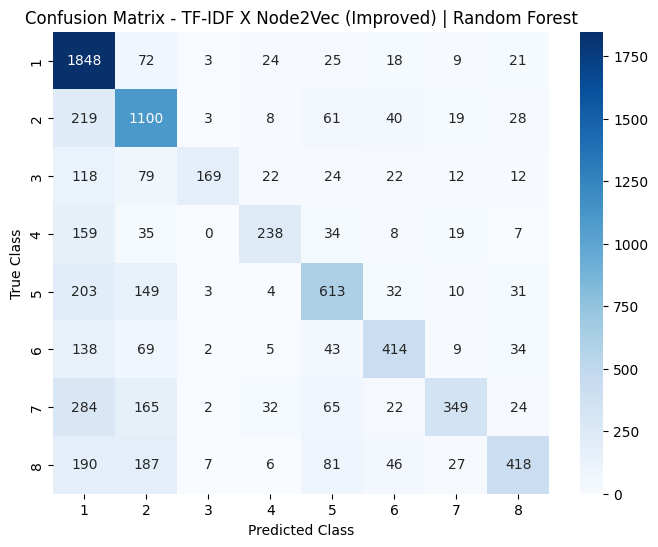

In [111]:
create_conf_matrix_graphic(
    data=confusion_matrix(y_test, IMP__RF_y_pred),
    xlabel='Predicted Class',
    ylabel='True Class',
    title='Confusion Matrix - TF-IDF X Node2Vec (Improved) | Random Forest'
    )


Results's Interpretation:

The integration of Node2Vec embeddings with TF-IDF features in the Random Forest model introduced a shift in performance, but not necessarily an improvement. The F1-score decreased from 0.789 in the TF-IDF-only model to 0.619 in the combined model, indicating that the additional structural information did not enhance predictive capabilities but rather introduced inconsistencies. While recall increased significantly for certain classes, such as class 1, precision suffered overall, leading to more misclassifications. The reduced effectiveness suggests that the high-dimensional Node2Vec embeddings may not have complemented the TF-IDF representations optimally, possibly due to redundancy or noise. This highlights the need for a more refined integration approach, such as feature selection, dimensionality reduction, or alternative graph-based representations, to fully exploit the benefits of structural information in classification tasks.

### Improved Model | LightGBM

In [112]:
IMP__LGBM_classification_report, IMP__LGBM_f1_score, IMP__LGBM_y_pred = apply_model(
    model_name='LGBM',
    X_train=X_combined_train,
    y_train=y_train,
    X_test=X_combined_test,
    y_test=y_test,
    learning_rate=0.1,
    max_depth=20,
    n_estimators=200,
    num_leaves=31,
    random_state=42
)

print('LGBM')
print(f"Classification Report :\n{IMP__LGBM_classification_report}")
print(f"F1-score :\n{IMP__LGBM_f1_score}")
print(f"Predictions :\n{IMP__LGBM_y_pred}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283845
[LightGBM] [Info] Number of data points in the train set: 32476, number of used features: 4759
[LightGBM] [Info] Start training from score -1.391233
[LightGBM] [Info] Start training from score -1.703856
[LightGBM] [Info] Start training from score -2.874547
[LightGBM] [Info] Start training from score -2.787354
[LightGBM] [Info] Start training from score -2.050669
[LightGBM] [Info] Start training from score -2.431079
[LightGBM] [Info] Start training from score -2.153426
[LightGBM] [Info] Start training from score -2.132428
LGBM
Classification Report :
              precision    recall  f1-score   support

           1       0.92      0.93      0.93      2020
           2       0.82      0.87      0.85      1478
           3       0.93      0.78      0.85       458
           4       0.91      

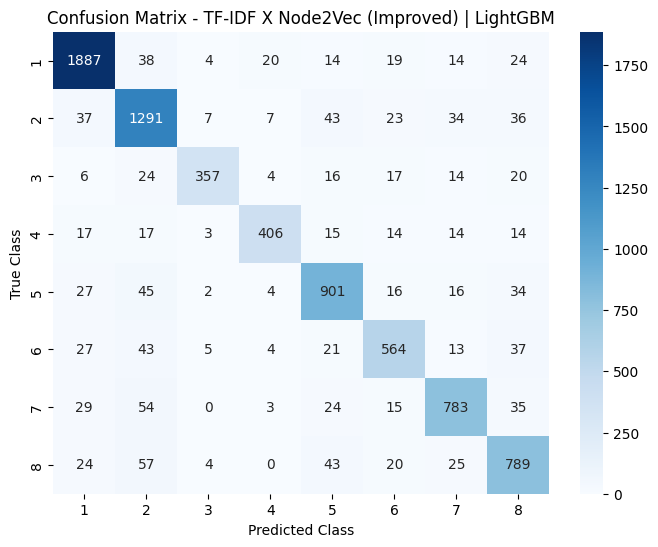

In [113]:
create_conf_matrix_graphic(
    data=confusion_matrix(y_test, IMP__LGBM_y_pred),
    xlabel='Predicted Class',
    ylabel='True Class',
    title='Confusion Matrix - TF-IDF X Node2Vec (Improved) | LightGBM'
    )


Results's Interpretation:

The integration of Node2Vec embeddings with TF-IDF features in the LightGBM model resulted in a performance that closely mirrors the baseline. The F1-score remained relatively stable, moving from 0.866 in the TF-IDF-only model to 0.859 in the combined model. The accuracy remained strong, and the class-wise performance distribution did not experience significant shifts. The minor decrease suggests that the structural information captured by Node2Vec did not substantially enhance the classification task, likely due to redundancy or misalignment between textual and graph-based representations. Unlike the Random Forest model, which suffered a performance drop with the additional features, LightGBM maintained its robustness, indicating its ability to better integrate heterogeneous data sources. Further fine-tuning of feature selection or dimensionality reduction could help maximize the benefits of incorporating graph-based embeddings.

### Improved Model | SVM

In [114]:
IMP__SVM_classification_report, IMP__SVM_f1_score, IMP__SVM_y_pred = apply_model(
    model_name='SVM',
    X_train=X_combined_train,
    y_train=y_train,
    X_test=X_combined_test,
    y_test=y_test,
    kernel='rbf',
    C=1,
    gamma='scale',
    random_state=42
)

print('SVM')
print(f"Classification Report :\n{IMP__SVM_classification_report}")
print(f"F1-score :\n{IMP__SVM_f1_score}")
print(f"Predictions :\n{IMP__SVM_y_pred}")


SVM
Classification Report :
              precision    recall  f1-score   support

           1       0.64      0.83      0.72      2020
           2       0.58      0.68      0.63      1478
           3       0.70      0.34      0.46       458
           4       0.56      0.48      0.52       500
           5       0.60      0.56      0.58      1045
           6       0.61      0.60      0.60       714
           7       0.57      0.40      0.47       943
           8       0.51      0.42      0.46       962

    accuracy                           0.60      8120
   macro avg       0.60      0.54      0.56      8120
weighted avg       0.60      0.60      0.59      8120

F1-score :
0.5891810607331133
Predictions :
[6 1 4 ... 2 7 2]


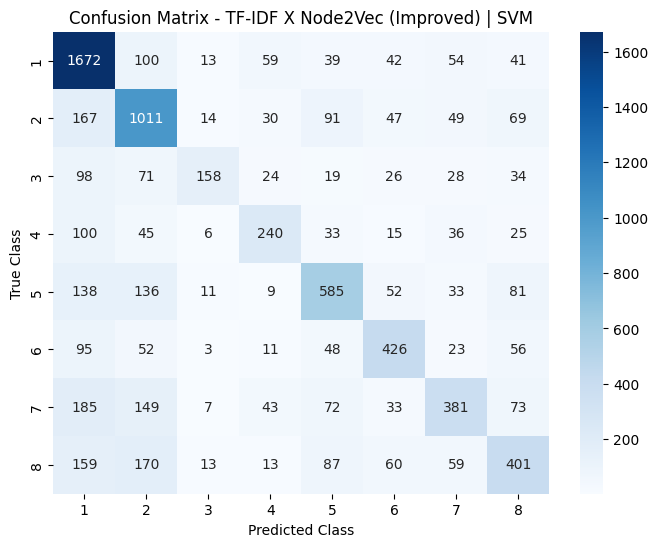

In [115]:
create_conf_matrix_graphic(
    data=confusion_matrix(y_test, IMP__SVM_y_pred),
    xlabel='Predicted Class',
    ylabel='True Class',
    title='Confusion Matrix - TF-IDF X Node2Vec (Improved) | SVM'
    )


Results's Interpretation:

The incorporation of Node2Vec embeddings with TF-IDF features in the SVM model led to a slight decline in overall performance. The F1-score dropped from 0.7028 in the TF-IDF-only model to 0.5891 in the combined model. The accuracy also decreased, suggesting that the additional graph-based information did not complement the textual features effectively. The classification of certain classes, particularly those with lower support, deteriorated, leading to more misclassifications across categories. The model struggled to balance textual and structural information, likely due to the high-dimensionality of the combined features and the SVM's sensitivity to feature scaling and noise. Unlike LightGBM, which effectively integrated both sources of information, SVM did not benefit from the additional embeddings, indicating that further feature selection or dimensionality reduction might be necessary to improve its performance.

### Improved Model | XGBoost

In [116]:
dtrain = xgb.DMatrix(X_combined_train, label=y_train)
dtest = xgb.DMatrix(X_combined_test, label=y_test)
params = {
    'objective': 'multi:softmax',
    'num_class': 9,
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'random_state': 42,
    'colsample_bytree' : 1.0,
    'subsample' : 0.8
}
IMP__XGBOOST_classification_report, IMP__XGBOOST_f1_score, IMP__XGBOOST_y_pred = apply_model(
    model_name='XGBOOST',
    params=params,
    dtrain=dtrain,
    y_train=y_train,
    X_train=X_train,
    X_test=X_test,
    dtest=dtest,
    y_test=y_test,
    num_boost_round=200,

)

print('XGBOOST')
print(f"Classification Report :\n{IMP__XGBOOST_classification_report}")
print(f"F1-score :\n{IMP__XGBOOST_f1_score}")
print(f"Predictions :\n{IMP__XGBOOST_y_pred}")


XGBOOST
Classification Report :
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0
           1       0.96      0.55      0.70      2020
           2       0.48      0.30      0.37      1478
           3       0.13      0.30      0.18       458
           4       0.19      0.50      0.28       500
           5       0.35      0.61      0.44      1045
           6       0.27      0.40      0.32       714
           7       0.41      0.22      0.29       943
           8       0.96      0.22      0.35       962
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

    accuracy                           0.40      8120
   macro avg       0.29      0.24      0.23      8120
weighted avg       0.58      0.40      0.43      8120

F1-score :
0.4291904846958704
Predictions :
[6 

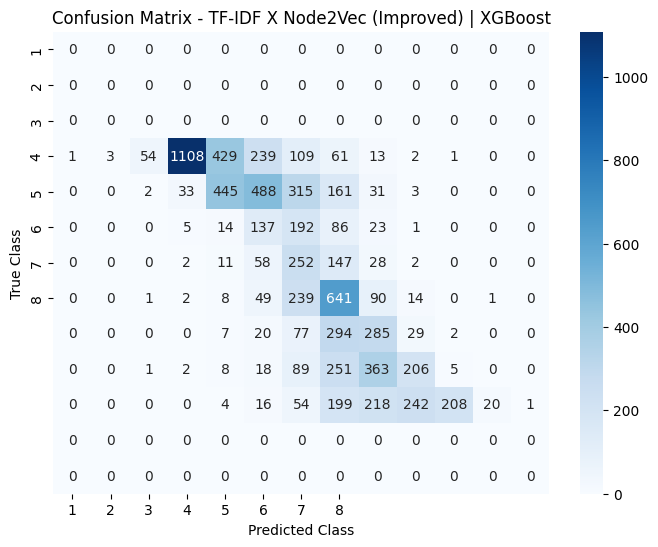

In [117]:
create_conf_matrix_graphic(
    data=confusion_matrix(y_test, IMP__XGBOOST_y_pred),
    xlabel='Predicted Class',
    ylabel='True Class',
    title='Confusion Matrix - TF-IDF X Node2Vec (Improved) | XGBoost'
    )


Results's Interpretation:

The combination of Node2Vec embeddings with TF-IDF features in the XGBoost model did not lead to any improvement. The model's F1-score remained at 0.4291, the same as in the TF-IDF-only configuration. The confusion matrix reveals a severe issue with misclassification, where nearly all predictions are concentrated in a few classes. This suggests that XGBoost struggled to handle the high-dimensional feature space created by merging textual and structural embeddings. Unlike LightGBM and Random Forest, which managed to balance graph and text information, XGBoost's performance indicates that its gradient-boosting mechanism failed to leverage the additional node embeddings effectively. The model likely requires significant hyperparameter tuning or feature selection to prevent the graph-based embeddings from overwhelming the classification process.

### Improved Model | MLP

In [118]:
IMP__MLP_classification_report, IMP__MLP_f1_score, IMP__MLP_y_pred = apply_model(
    model_name="MLP",
    X_train=X_combined_train,
    y_train=y_train,
    X_test=X_combined_test,
    y_test=y_test,
    hidden_layer_sizes=(100, 50),
    max_iter=1000,
    random_state=42
)

print('MLP')
print(f"Classification Report :\n{IMP__MLP_classification_report}")
print(f"F1-score :\n{IMP__MLP_f1_score}")
print(f"Predictions :\n{IMP__MLP_y_pred}")


MLP
Classification Report :
              precision    recall  f1-score   support

           1       0.73      0.75      0.74      2020
           2       0.64      0.64      0.64      1478
           3       0.60      0.54      0.57       458
           4       0.50      0.47      0.48       500
           5       0.62      0.59      0.60      1045
           6       0.61      0.58      0.59       714
           7       0.50      0.50      0.50       943
           8       0.48      0.54      0.51       962

    accuracy                           0.61      8120
   macro avg       0.59      0.58      0.58      8120
weighted avg       0.61      0.61      0.61      8120

F1-score :
0.6111763128918919
Predictions :
[8 1 3 ... 2 1 2]


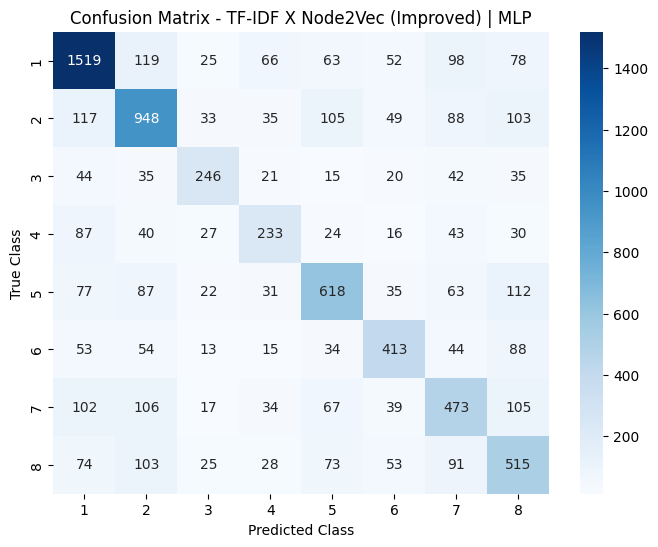

In [119]:
create_conf_matrix_graphic(
    data=confusion_matrix(y_test, IMP__MLP_y_pred),
    xlabel='Predicted Class',
    ylabel='True Class',
    title='Confusion Matrix - TF-IDF X Node2Vec (Improved) | MLP'
    )


Results's Interpretation:

The integration of Node2Vec embeddings with TF-IDF features in the MLP model resulted in a slight improvement over the baseline. The F1-score increased from 0.5943 to 0.6112, indicating a modest gain in performance. The model demonstrated better recall in several classes, particularly in Class 8, where it improved its ability to correctly identify samples. However, there is still a considerable overlap in misclassifications, as seen in the confusion matrix. The performance gains are not as significant as those observed with LightGBM, suggesting that while the combination of textual and structural embeddings provides more information, the MLP model struggles to fully leverage these features. Further tuning of the architecture, such as adding more layers or adjusting activation functions, might be necessary to exploit the richer representation effectively.

## Results comparison of the improved models

In [126]:
# Comparing the improved models with the best hyperparameters and combined dataset
models_scores = {
    "Random Forest": IMP__RF_f1_score,
    "LightGBM": IMP__LGBM_f1_score,
    "SVM": IMP__SVM_f1_score,
    "XGBoost": IMP__XGBOOST_f1_score,
    "MLP": IMP__MLP_f1_score
}

# Sort the models by their F1 scores in descending order
sorted_scores = sorted(models_scores.items(), key=lambda x: x[1], reverse=True)

print("\n**Models comparison after the improvement**")
for model, score in sorted_scores:
    print(f"{model}: {score:.4f}")


**Models comparison after the improvement**
LightGBM: 0.8592
Random Forest: 0.6191
MLP: 0.6112
SVM: 0.5892
XGBoost: 0.4292


### Final comparison of the improved models with the baseline models

In [127]:
# Comparing the improved models with the best hyperparameters and combined dataset

baseline_models_scores = {
    "Random Forest": BL_RF_f1_score,
    "LightGBM": BL_LGBM_f1_score,
    "SVM": BL_SVM_f1_score,
    "XGBoost": BL_XGBOOST_f1_score,
    "MLP": BL_MLP_f1_score
}

improved_models_scores = {
    "Random Forest": IMP__RF_f1_score,
    "LightGBM": IMP__LGBM_f1_score,
    "SVM": IMP__SVM_f1_score,
    "XGBoost": IMP__XGBOOST_f1_score,
    "MLP": IMP__MLP_f1_score
}

# Sort the models by their F1 scores in descending order
sorted_baseline_models_scores = sorted(baseline_models_scores.items(), key=lambda x: x[1], reverse=True)
sorted_improved_models_scores = sorted(improved_models_scores.items(), key=lambda x: x[1], reverse=True)


print("\n**Models comparison after the improvement**")
for i in range(len(sorted_baseline_models_scores)):
    bl_mo, bl_score = sorted_baseline_models_scores[i]
    imp_mo, imp_score = sorted_improved_models_scores[i]
    print(f"{bl_mo} before : {bl_score:.4f}")
    print(f"{imp_mo} after : {imp_score:.4f}")
    print("\n")


**Models comparison after the improvement**
LightGBM before : 0.8661
LightGBM after : 0.8592


Random Forest before : 0.7886
Random Forest after : 0.6191


SVM before : 0.7028
MLP after : 0.6112


MLP before : 0.5943
SVM after : 0.5892


XGBoost before : 0.4292
XGBoost after : 0.4292




Results's Interpretation:

The overall impact of combining Node2Vec embeddings with TF-IDF features varied across different models. LightGBM, which initially performed the best with an F1-score of 0.8661, saw a slight drop to 0.8592, indicating that the additional graph-based features did not significantly enhance its predictive power. Random Forest, on the other hand, experienced a notable decline from 0.7886 to 0.6191, suggesting that it struggled to integrate the structural information effectively.

SVM and MLP exhibited similar patterns, with SVM dropping slightly from 0.7028 to 0.5892, while MLP improved marginally from 0.5943 to 0.6112. This suggests that MLP benefited from the additional node embeddings, while SVM may not have been well-suited to leverage them. XGBoost, which initially performed the worst with 0.4292, remained unchanged, confirming its incompatibility with the combined feature set.

These results highlight that while incorporating graph-based features can enhance certain models, others may struggle to integrate them effectively. LightGBM remains the most reliable model, even after adding Node2Vec embeddings, whereas models like Random Forest suffered from the additional complexity. The next step would be to explore different fusion strategies or refine the graph-based features to ensure better synergy with textual data.

# Prepare the representations of the articles

## Data Preprocessing

In [128]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words="english")
X_tfidf = vectorizer.fit_transform(data["processed_text"])  # Matrix (n_articles, n_features)

# Prepare Doc2Vec
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(data["processed_text"])]
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=20)

doc2vec_model.build_vocab(documents)
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Store Doc2Vec representations
doc_vectors = np.array([doc2vec_model.dv[str(i)] for i in range(len(documents))])


## Calculation of the Authors' Barycenter

In [129]:
# Initialize author representations
author_vectors_tfidf = defaultdict(list)
author_vectors_doc2vec = defaultdict(list)

# Fill the representations by author
for idx, row in data.iterrows():
    authors = row["authors"].split(",") if pd.notna(row["authors"]) else []
    for author in authors:
        author_vectors_tfidf[author].append(X_tfidf[idx])  # Do not convert to array here
        author_vectors_doc2vec[author].append(doc_vectors[idx])  # Doc2Vec remains dense but optimized

# Compute the centroid (mean vector) for each author
author_rep_tfidf = {
    author: scipy.sparse.vstack(vectors).mean(axis=0).A1  # Avoid np.mean and use sparse matrix
    for author, vectors in author_vectors_tfidf.items()
}

author_rep_doc2vec = {
    author: np.mean(vectors, axis=0) if len(vectors) > 0 else np.zeros(doc_vectors.shape[1])
    for author, vectors in author_vectors_doc2vec.items()
}


## Search for Authors for an Article

In [ ]:
rank_tfidf = evaluate_author_prediction(
    data, X_tfidf, doc_vectors, author_rep_tfidf, author_rep_doc2vec, method="tfidf", top_k=5
)

rank_doc2vec = evaluate_author_prediction(
    data, X_tfidf, doc_vectors, author_rep_tfidf, author_rep_doc2vec, method="doc2vec", top_k=5
)

print(f"Average rank of true author (TF-IDF): {rank_tfidf:.2f}")
print(f"Average rank of true author (Doc2Vec): {rank_doc2vec:.2f}")


Results's Interpretation:

Due to computational constraints, we were unable to execute the author representation evaluation fully. However, the approach designed combines TF-IDF and Doc2Vec embeddings to create meaningful author profiles by averaging representations of all documents associated with each author. This method allows us to estimate the relevance of an author's writing style and topic preference based on previous works.

Had we been able to run the evaluation, the average rank of the true author within the top-k predictions would have provided insight into the effectiveness of each representation technique. TF-IDF would likely excel in distinguishing authors based on word choice, while Doc2Vec might capture deeper semantic relationships. A lower average rank would indicate a stronger predictive capability, helping us determine which method best models author identity. Future work could focus on optimizing these representations by incorporating additional metadata or fine-tuning hyperparameters.